# ***CPU***

## **CPU constants and utilities**

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import json
import os
from datetime import datetime
from enum import Enum
import re
import time
import csv

TNEG, TZERO, TPOS = -1, 0, 1
MODEL_DIR = "models"

class TernarySignal:
    def __init__(self, value):
        # Convert unbalanced to balanced automatically
        if value in [0, 1, 2]:
            value = value - 1  # Maps 0→-1, 1→0, 2→+1
        if value not in [-1, 0, 1]:
            raise ValueError(f"Invalid ternary signal: {value}")
        self.value = value

    def __str__(self):
        return str(self.value)

def int_to_ternary(n, digits=5):
    """Convert integer to ternary representation"""
    if n < 0:
        raise ValueError("Only non-negative integers supported")

    base3 = []
    for _ in range(digits):
        n, r = divmod(n, 3)
        base3.append(r - 1)  # Convert to -1, 0, 1 representation
    return base3[::-1]

def ternary_to_int(t):
    """Convert ternary to integer"""
    return sum((v + 1) * (3 ** i) for i, v in enumerate(reversed(t)))

def display_ternary(t):
    """Display ternary in readable format"""
    symbols = {-1: '-', 0: '0', 1: '+'}
    return ''.join(symbols[x] for x in t)

def one_hot_encode(y, num_classes=3):
    encoded = np.zeros((len(y), num_classes))
    for i, val in enumerate(y):
        encoded[i, val] = 1
    return encoded

# Gate functions
def ternary_and(a, b): return min(a, b)
def ternary_or(a, b): return max(a, b)
def ternary_xor(a, b): return (a - b) % 3
def ternary_nand(a, b): return 2 - min(a, b)
def ternary_nor(a, b): return 2 - max(a, b)


## ***CPU components***

### **Programm Counter**

In [56]:
class ProgramCounter:
    """Program Counter for instruction sequencing"""
    def __init__(self):
        self.value = 0
        self.max_value = 242  # 3^5 - 1 for 5-trit addressing

    def increment(self):
        self.value = (self.value + 1) % (self.max_value + 1)

    def jump(self, address):
        if 0 <= address <= self.max_value:
            self.value = address
        else:
            raise ValueError(f"Address {address} out of range [0, {self.max_value}]")

    def get(self):
        return self.value

    def reset(self):
        self.value = 0


### **Register sets**

In [57]:
class RegisterSet:
    """Ternary register set with 3 registers (R0, R1, R2)"""
    def __init__(self, num_registers=3):
        self.registers = [0] * num_registers
        self.num_registers = num_registers

    def read(self, idx):
        if 0 <= idx < self.num_registers:
            return self.registers[idx]
        raise ValueError(f"Register R{idx} does not exist")

    def write(self, idx, value):
        if 0 <= idx < self.num_registers:
            # Keep values in ternary range [0, 1, 2]
            self.registers[idx] = value % 3
        else:
            raise ValueError(f"Register R{idx} does not exist")

    def display(self):
        print("=== REGISTERS ===")
        for i, val in enumerate(self.registers):
            ternary_val = int_to_ternary(val, 3)
            print(f"R{i}: {val:3d} ({display_ternary(ternary_val)})")

### **Ternary Memory**

In [58]:
class TernaryMemory:
    """Ternary memory system"""
    def __init__(self, size=243):  # 3^5 addresses
        self.memory = [0] * size
        self.size = size

    def load(self, addr, value):
        if 0 <= addr < self.size:
            self.memory[addr] = value % 3
        else:
            raise ValueError(f"Memory address {addr} out of range")

    def read(self, addr):
        if 0 <= addr < self.size:
            return self.memory[addr]
        else:
            raise ValueError(f"Memory address {addr} out of range")

    def display(self, start=0, count=16):
        print(f"=== MEMORY [{start}:{start+count-1}] ===")
        for i in range(start, min(start + count, self.size)):
            if self.memory[i] != 0:  # Only show non-zero values
                ternary_val = int_to_ternary(self.memory[i], 3)
                print(f"[{i:3d}]: {self.memory[i]:3d} ({display_ternary(ternary_val)})")

### **Ternary Gates**

In [59]:
class TernaryGate:
    @staticmethod
    def TAND(a: TernarySignal, b: TernarySignal) -> TernarySignal:
        # Truth table: Minimum of two trits
        return TernarySignal(min(a.value, b.value))

    @staticmethod
    def TOR(a: TernarySignal, b: TernarySignal) -> TernarySignal:
        # Truth table: Maximum of two trits
        return TernarySignal(max(a.value, b.value))

    @staticmethod
    def TXOR(a: TernarySignal, b: TernarySignal) -> TernarySignal:
        # Custom ternary XOR: Cyclic +1 mod 3
        table = {
            (-1, -1):  0,
            (-1, 0):   1,
            (-1, 1):  -1,
            (0, -1):   1,
            (0, 0):    0,
            (0, 1):   -1,
            (1, -1):  -1,
            (1, 0):   -1,
            (1, 1):    0,
        }
        return TernarySignal(table[(a.value, b.value)])

### **Ternary Alu**

In [60]:
class TernaryALU:
    """Refactored Ternary Arithmetic Logic Unit with pipelined interface."""

    def __init__(self):
        self.flags = {'zero': False, 'carry': False}
        self.pipeline = [None, None]  # [EX, WB]

    def execute(self, opcode, a, b):
        """Single-cycle ternary ALU computation."""
        a, b = TernarySignal(a), TernarySignal(b)

        if opcode == "TAND":
            result = TernaryGate.TAND(a, b).value
        elif opcode == "TOR":
            result = TernaryGate.TOR(a, b).value
        elif opcode == "TXOR":
            result = TernaryGate.TXOR(a, b).value
        elif opcode == "ADD":
            result = (a.value + b.value) % 3
            self.flags['carry'] = (a.value + b.value) >= 3
        elif opcode == "SUB":
            result = (a.value - b.value) % 3
            self.flags['carry'] = (a.value - b.value) < 0
        elif opcode == "AND":
            result = min(a.value, b.value)
        elif opcode == "OR":
            result = max(a.value, b.value)
        elif opcode == "XOR":
            result = (a.value - b.value) % 3
        elif opcode == "CMP":
            diff = a.value - b.value
            result = 0 if diff == 0 else (1 if diff > 0 else 2)
        else:
            raise ValueError(f"Unknown opcode: {opcode}")

        self.flags['zero'] = (result == 0)
        return result

    def tick(self, instr):
        """Simulate one pipeline step (EX → WB)."""
        self.pipeline[1] = self.pipeline[0]
        if instr:
            opcode, a, b = instr["opcode"], instr["a"], instr["b"]
            self.pipeline[0] = self.execute(opcode, a, b)
        else:
            self.pipeline[0] = None
        return self.pipeline[1]  # Output of WB stage


### **OpCode (Assembly like programm)**

In [61]:
class OpCode(Enum):
    # Data Movement
    LOAD = 0    # LOAD Rx, addr    - Load from memory to register
    STORE = 1   # STORE Rx, addr   - Store register to memory
    MOV = 2     # MOV Rx, Ry       - Move register to register

    # Arithmetic
    ADD = 3     # ADD Rx, Ry       - Add registers
    SUB = 4     # SUB Rx, Ry       - Subtract registers

    # Logic
    AND = 5     # AND Rx, Ry       - Ternary AND
    OR = 6      # OR Rx, Ry        - Ternary OR
    XOR = 7     # XOR Rx, Ry       - Ternary XOR

    # Control Flow
    JMP = 8     # JMP addr         - Unconditional jump
    JEQ = 9     # JEQ addr         - Jump if equal (zero flag)
    JNE = 10    # JNE addr         - Jump if not equal

    # Immediate Operations
    LOADI = 11  # LOADI Rx, value  - Load immediate value
    ADDI = 12   # ADDI Rx, value   - Add immediate value

    # System
    HLT = 13    # HLT              - Halt execution
    NOP = 14    # NOP              - No operation
    PRINT = 15  # PRINT Rx         - Print register value


## **FGPA like implementation**

### **Pipeline Components**

In [62]:
class PipelineStage:
    def __init__(self, name):
        self.name = name
        self.data = None

class PipelineState:
    def __init__(self):
        self.IF = {"opcode": "NOP", "src": [], "dest": None}
        self.ID = {"opcode": "NOP", "src": [], "dest": None}
        self.EX = {"opcode": "NOP", "src": [], "dest": None}
        self.MEM = {"opcode": "NOP", "src": [], "dest": None}
        self.WB = {"opcode": "NOP", "src": [], "dest": None}

    def advance(self, new_IF):
        self.WB = self.MEM
        self.MEM = self.EX
        self.EX = self.ID
        self.ID = self.IF
        self.IF = new_IF


### **Data Hazard + Forwarding**

In [63]:
def detect_data_hazard(id_instr, ex_instr, mem_instr, wb_instr):
    if not id_instr or not isinstance(id_instr, dict):
        return False

    hazard = False
    id_src = id_instr.get('src', [])

    for instr, stage_name in [(ex_instr, 'EX'), (mem_instr, 'MEM'), (wb_instr, 'WB')]:
        if instr and isinstance(instr, dict):
            dest = instr.get('dest')
            if dest is not None and dest in id_src:
                hazard = True
                break

    return hazard

def forwarding_values(registers, instr, ex_instr, ex_result, mem_instr, mem_result):
    forwarded = []
    for src in instr.get("src", []):
        if ex_instr and src == ex_instr.get("dest"):
            forwarded.append(ex_result)
        elif mem_instr and src == mem_instr.get("dest"):
            forwarded.append(mem_result)
        else:
            forwarded.append(registers[src])
    return forwarded

class TernaryPipelinedCPU:
    def __init__(self):
        self.registers = [0, 0, 0]
        self.pc = 0
        self.memory = TernaryMemory()
        self.alu = TernaryALU()

        # Pipeline stages
        self.IF = PipelineStage("IF")
        self.ID = PipelineStage("ID")
        self.EX = PipelineStage("EX")
        self.MEM = PipelineStage("MEM")
        self.WB = PipelineStage("WB")
        self.program = []

    def load_program(self, program):
        self.program = program

    def advance_pipeline(self):
        # Write Back
        if self.WB.data and isinstance(self.WB.data, tuple) and len(self.WB.data) == 2:
            dest, value = self.WB.data
            if dest is not None and 0 <= dest < len(self.registers):
                self.registers[dest] = value

        # Memory Access
        if self.MEM.data:
            self.WB.data = self.MEM.data

        # Execute
        if self.EX.data and isinstance(self.EX.data, tuple) and len(self.EX.data) >= 4:
            opcode, a_val, b_val, dest = self.EX.data
            if opcode != "NOP":
                result = self.alu.execute(opcode, a_val, b_val)
                self.MEM.data = (dest, result)
            else:
                self.MEM.data = None
        else:
            self.MEM.data = None

        # Decode
        if self.ID.data and isinstance(self.ID.data, dict):
            opcode = self.ID.data.get("opcode")
            src = self.ID.data.get("src", [])
            dest = self.ID.data.get("dest")

            if opcode and opcode != "NOP" and len(src) >= 2:
                a_idx, b_idx = src[0], src[1]
                if 0 <= a_idx < len(self.registers) and 0 <= b_idx < len(self.registers):
                    a_val = self.registers[a_idx]
                    b_val = self.registers[b_idx]
                    self.EX.data = (opcode, a_val, b_val, dest)
                else:
                    self.EX.data = ("NOP", 0, 0, None)
            else:
                self.EX.data = ("NOP", 0, 0, None)
        else:
            self.EX.data = ("NOP", 0, 0, None)

        # Fetch
        if self.pc < len(self.program):
            instr = self.program[self.pc]
            self.ID.data = instr
            self.pc += 1
        else:
            self.ID.data = {"opcode": "NOP", "src": [], "dest": None}

    def run(self, max_cycles=100):
        cycle = 0
        while cycle < max_cycles:
            self.advance_pipeline()
            cycle += 1

            # Check if pipeline is empty
            if (self.ID.data.get("opcode") == "NOP" and
                (not self.EX.data or self.EX.data[0] == "NOP") and
                not self.MEM.data and not self.WB.data and
                self.pc >= len(self.program)):
                break

        return cycle

In [64]:
class TernaryGateNN:
    def __init__(self, input_neurons=2, hidden1=16, hidden2=12, hidden3=8, output_neurons=3, lr=0.01):
        self.lr = lr
        # Xavier initialization for better convergence
        self.W1 = np.random.normal(0, np.sqrt(2/input_neurons), (input_neurons, hidden1))
        self.b1 = np.zeros((1, hidden1))
        self.W2 = np.random.normal(0, np.sqrt(2/hidden1), (hidden1, hidden2))
        self.b2 = np.zeros((1, hidden2))
        self.W3 = np.random.normal(0, np.sqrt(2/hidden2), (hidden2, hidden3))
        self.b3 = np.zeros((1, hidden3))
        self.W4 = np.random.normal(0, np.sqrt(2/hidden3), (hidden3, output_neurons))
        self.b4 = np.zeros((1, output_neurons))

        # Enhanced training history with comprehensive loss tracking
        self.training_history = []
        self.loss_components = {
            'cross_entropy': [],
            'l2_regularization': [],
            'total_loss': [],
            'gradient_norm': [],
            'learning_rate_changes': []
        }

        # Performance metrics
        self.performance_metrics = {
            'epoch_times': [],
            'convergence_rate': [],
            'stability_score': []
        }

    def relu(self, x):
        return np.maximum(0, x)

    def relu_derivative(self, x):
        return (x > 0).astype(float)

    def leaky_relu(self, x, alpha=0.01):
        return np.where(x > 0, x, alpha * x)

    def leaky_relu_derivative(self, x, alpha=0.01):
        return np.where(x > 0, 1, alpha)

    def softmax(self, x):
        exp = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp / np.sum(exp, axis=1, keepdims=True)

    def predict_proba(self, X):
        h1 = self.leaky_relu(np.dot(X, self.W1) + self.b1)
        h2 = self.leaky_relu(np.dot(h1, self.W2) + self.b2)
        h3 = self.leaky_relu(np.dot(h2, self.W3) + self.b3)
        out = np.dot(h3, self.W4) + self.b4
        return self.softmax(out)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

    def cross_entropy_loss(self, y_true, y_pred):
        """Calculate cross-entropy loss"""
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))

    def l2_regularization_loss(self, l2_lambda=0.001):
        """Calculate L2 regularization loss"""
        l2_loss = 0
        l2_loss += np.sum(self.W1 ** 2)
        l2_loss += np.sum(self.W2 ** 2)
        l2_loss += np.sum(self.W3 ** 2)
        l2_loss += np.sum(self.W4 ** 2)
        return l2_lambda * l2_loss

    def gradient_norm(self, gradients):
        """Calculate total gradient norm for monitoring"""
        total_norm = 0
        for grad in gradients:
            total_norm += np.sum(grad ** 2)
        return np.sqrt(total_norm)

    def adaptive_learning_rate(self, epoch, base_lr, decay_rate=0.95, decay_steps=500):
        """Adaptive learning rate with decay"""
        return base_lr * (decay_rate ** (epoch // decay_steps))

    def train(self, X, Y, epochs=2000, patience=100, verbose=True, track_detailed_metrics=True):
        """Enhanced training with comprehensive loss tracking"""
        best_loss = float('inf')
        patience_counter = 0
        base_lr = self.lr

        # Reset tracking
        if track_detailed_metrics:
            self.training_history = []
            self.loss_components = {
                'cross_entropy': [],
                'l2_regularization': [],
                'total_loss': [],
                'gradient_norm': [],
                'learning_rate_changes': []
            }
            self.performance_metrics = {
                'epoch_times': [],
                'convergence_rate': [],
                'stability_score': []
            }

        for epoch in range(epochs):
            epoch_start_time = datetime.now()

            # Adaptive learning rate
            self.lr = self.adaptive_learning_rate(epoch, base_lr)

            # Forward pass
            z1 = np.dot(X, self.W1) + self.b1
            a1 = self.leaky_relu(z1)
            z2 = np.dot(a1, self.W2) + self.b2
            a2 = self.leaky_relu(z2)
            z3 = np.dot(a2, self.W3) + self.b3
            a3 = self.leaky_relu(z3)
            z4 = np.dot(a3, self.W4) + self.b4
            output = self.softmax(z4)

            # Calculate loss components
            ce_loss = self.cross_entropy_loss(Y, output)
            l2_loss = self.l2_regularization_loss()
            total_loss = ce_loss + l2_loss

            # Calculate accuracy
            preds = np.argmax(output, axis=1)
            true_labels = np.argmax(Y, axis=1)
            acc = np.mean(preds == true_labels)

            # Backpropagation
            error = output - Y

            # Output layer gradients
            dW4 = np.dot(a3.T, error) / len(X)
            db4 = np.sum(error, axis=0, keepdims=True) / len(X)

            # Hidden layer 3 gradients
            delta3 = np.dot(error, self.W4.T) * self.leaky_relu_derivative(z3)
            dW3 = np.dot(a2.T, delta3) / len(X)
            db3 = np.sum(delta3, axis=0, keepdims=True) / len(X)

            # Hidden layer 2 gradients
            delta2 = np.dot(delta3, self.W3.T) * self.leaky_relu_derivative(z2)
            dW2 = np.dot(a1.T, delta2) / len(X)
            db2 = np.sum(delta2, axis=0, keepdims=True) / len(X)

            # Hidden layer 1 gradients
            delta1 = np.dot(delta2, self.W2.T) * self.leaky_relu_derivative(z1)
            dW1 = np.dot(X.T, delta1) / len(X)
            db1 = np.sum(delta1, axis=0, keepdims=True) / len(X)

            # Calculate gradient norm
            gradients = [dW1, dW2, dW3, dW4, db1, db2, db3, db4]
            grad_norm = self.gradient_norm(gradients)

            # Update weights with L2 regularization
            l2_reg = 0.001
            self.W4 -= self.lr * (dW4 + l2_reg * self.W4)
            self.b4 -= self.lr * db4
            self.W3 -= self.lr * (dW3 + l2_reg * self.W3)
            self.b3 -= self.lr * db3
            self.W2 -= self.lr * (dW2 + l2_reg * self.W2)
            self.b2 -= self.lr * db2
            self.W1 -= self.lr * (dW1 + l2_reg * self.W1)
            self.b1 -= self.lr * db1

            # Track detailed metrics
            if track_detailed_metrics:
                epoch_time = (datetime.now() - epoch_start_time).total_seconds()

                # Store comprehensive metrics
                self.training_history.append({
                    'epoch': epoch,
                    'loss': total_loss,
                    'accuracy': acc,
                    'cross_entropy_loss': ce_loss,
                    'l2_loss': l2_loss,
                    'gradient_norm': grad_norm,
                    'learning_rate': self.lr,
                    'epoch_time': epoch_time
                })

                self.loss_components['cross_entropy'].append(ce_loss)
                self.loss_components['l2_regularization'].append(l2_loss)
                self.loss_components['total_loss'].append(total_loss)
                self.loss_components['gradient_norm'].append(grad_norm)
                self.performance_metrics['epoch_times'].append(epoch_time)

                # Calculate convergence rate (change in loss)
                if epoch > 0:
                    loss_change = abs(total_loss - self.loss_components['total_loss'][-2])
                    self.performance_metrics['convergence_rate'].append(loss_change)

            # Early stopping
            if total_loss < best_loss:
                best_loss = total_loss
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= patience and acc >= 0.99:
                if verbose:
                    print(f"Early stopping at epoch {epoch}, Loss: {total_loss:.6f}, Accuracy: {acc*100:.2f}%")
                break

            # Perfect accuracy achieved
            if acc == 1.0:
                if verbose:
                    print(f"Perfect accuracy achieved at epoch {epoch}!")
                break

            # Print progress with detailed loss information
            if verbose and (epoch % 200 == 0 or acc == 1.0):
                print(f"Epoch {epoch:4d}: Total Loss={total_loss:.6f} (CE: {ce_loss:.6f}, L2: {l2_loss:.6f}), "
                      f"Accuracy={acc*100:.2f}%, Grad Norm={grad_norm:.4f}, LR={self.lr:.5f}")

        # Calculate final stability score
        if track_detailed_metrics and len(self.performance_metrics['convergence_rate']) > 10:
            recent_convergence = self.performance_metrics['convergence_rate'][-10:]
            stability = 1.0 / (1.0 + np.std(recent_convergence))
            self.performance_metrics['stability_score'] = stability

    def get_loss_summary(self):
        """Get comprehensive loss summary"""
        if not self.training_history:
            return "No training history available"

        latest = self.training_history[-1]

        summary = {
            'final_epoch': latest['epoch'],
            'final_total_loss': latest['loss'],
            'final_cross_entropy': latest['cross_entropy_loss'],
            'final_l2_loss': latest['l2_loss'],
            'final_accuracy': latest['accuracy'],
            'final_gradient_norm': latest['gradient_norm'],
            'avg_epoch_time': np.mean(self.performance_metrics['epoch_times']),
            'total_training_time': sum(self.performance_metrics['epoch_times'])
        }

        if self.performance_metrics['stability_score']:
            summary['stability_score'] = self.performance_metrics['stability_score']

        return summary

    def get_weights(self):
        return {
            'W1': self.W1.copy(), 'b1': self.b1.copy(),
            'W2': self.W2.copy(), 'b2': self.b2.copy(),
            'W3': self.W3.copy(), 'b3': self.b3.copy(),
            'W4': self.W4.copy(), 'b4': self.b4.copy(),
            'training_history': self.training_history.copy(),
            'loss_components': self.loss_components.copy(),
            'performance_metrics': self.performance_metrics.copy()
        }

    def set_weights(self, weights):
        self.W1 = weights['W1'].copy()
        self.b1 = weights['b1'].copy()
        self.W2 = weights['W2'].copy()
        self.b2 = weights['b2'].copy()
        self.W3 = weights['W3'].copy()
        self.b3 = weights['b3'].copy()
        self.W4 = weights['W4'].copy()
        self.b4 = weights['b4'].copy()
        if 'training_history' in weights:
            self.training_history = weights['training_history'].copy()
        if 'loss_components' in weights:
            self.loss_components = weights['loss_components'].copy()
        if 'performance_metrics' in weights:
            self.performance_metrics = weights['performance_metrics'].copy()

    def clone(self):
        new_model = TernaryGateNN()
        new_model.set_weights(self.get_weights())
        return new_model

# ============================================================================
# BENCHMARK SYSTEM
# ============================================================================

class TernaryBenchmark:
    def __init__(self, alu, enable_csv=False, csv_path="benchmark_log.csv"):
        self.alu = alu
        self.enable_csv = enable_csv
        self.csv_path = csv_path
        self.reset_stats()

        if self.enable_csv:
            with open(self.csv_path, 'w', newline='') as f:
                writer = csv.writer(f)
                writer.writerow(["Cycle", "Opcode", "A", "B", "Result", "Time (ms)", "Zero Flag", "Carry Flag"])

    def reset_stats(self):
        self.total_cycles = 0
        self.instruction_count = 0
        self.total_time = 0.0
        self.zero_count = 0
        self.carry_count = 0

    def run_program(self, instructions):
        results = []
        for instr in instructions:
            start = time.perf_counter()
            result = self.alu.tick(instr)
            end = time.perf_counter()

            self.total_cycles += 1
            if result is not None:
                self.instruction_count += 1
                self.total_time += (end - start)
                if self.alu.flags['zero']: self.zero_count += 1
                if self.alu.flags['carry']: self.carry_count += 1

                if self.enable_csv:
                    with open(self.csv_path, 'a', newline='') as f:
                        writer = csv.writer(f)
                        writer.writerow([
                            self.total_cycles,
                            instr['opcode'],
                            instr['a'], instr['b'],
                            result,
                            round((end - start) * 1000, 3),
                            self.alu.flags['zero'],
                            self.alu.flags['carry']
                        ])

                results.append(result)
        return results

    def summary(self):
        avg_time = (self.total_time / self.instruction_count) * 1000 if self.instruction_count else 0
        print("\n--- Ternary ALU Benchmark Summary ---")
        print(f"Total cycles        : {self.total_cycles}")
        print(f"Instructions executed: {self.instruction_count}")
        print(f"Average time (ms)   : {avg_time:.4f}")
        print(f"Zero flag frequency : {self.zero_count / max(1, self.instruction_count):.2%}")
        print(f"Carry flag frequency: {self.carry_count / max(1, self.instruction_count):.2%}")
        print("--------------------------------------\n")

# ============================================================================
# MODEL PERSISTENCE
# ============================================================================

def save_model(model, gate_name):
    """Save model with comprehensive metadata including loss tracking"""
    os.makedirs(MODEL_DIR, exist_ok=True)

    final_acc = model.training_history[-1]['accuracy'] if model.training_history else 0
    loss_summary = model.get_loss_summary()

    model_data = {
        'gate_name': gate_name,
        'weights': model.get_weights(),
        'final_accuracy': final_acc,
        'training_epochs': len(model.training_history),
        'timestamp': datetime.now().isoformat(),
        'model_version': '3.0',
        'loss_summary': loss_summary
    }

    # Save as .npz for weights and .json for metadata
    weights = model.get_weights()
    np.savez(f"{MODEL_DIR}/{gate_name}_weights.npz",
             **{k: v for k, v in weights.items() if isinstance(v, np.ndarray)})

    # Save metadata separately (including loss tracking)
    metadata = {k: v for k, v in model_data.items() if k != 'weights'}
    metadata['training_history'] = weights.get('training_history', [])
    metadata['loss_components'] = weights.get('loss_components', {})
    metadata['performance_metrics'] = weights.get('performance_metrics', {})

    with open(f"{MODEL_DIR}/{gate_name}_metadata.json", 'w') as f:
        json.dump(metadata, f, indent=2)

    print(f"[SAVE] Model saved for {gate_name} with {final_acc*100:.2f}% accuracy")
    if loss_summary and isinstance(loss_summary, dict):
        print(f"       Final Loss: {loss_summary.get('final_total_loss', 'N/A'):.6f}")

def load_model(gate_name):
    """Load model with full restoration including loss tracking"""
    weights_path = f"{MODEL_DIR}/{gate_name}_weights.npz"
    metadata_path = f"{MODEL_DIR}/{gate_name}_metadata.json"

    if os.path.exists(weights_path) and os.path.exists(metadata_path):
        model = TernaryGateNN()

        # Load weights
        weights_data = np.load(weights_path)
        weights = {key: weights_data[key] for key in weights_data.files}

        # Load metadata
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)

        weights['training_history'] = metadata.get('training_history', [])
        weights['loss_components'] = metadata.get('loss_components', {})
        weights['performance_metrics'] = metadata.get('performance_metrics', {})
        model.set_weights(weights)

        print(f"[LOAD] Loaded {gate_name} model (Accuracy: {metadata['final_accuracy']*100:.2f}%)")
        if 'loss_summary' in metadata:
            loss_info = metadata['loss_summary']
            if isinstance(loss_info, dict):
                print(f"       Final Loss: {loss_info.get('final_total_loss', 'N/A'):.6f}")
        return model, metadata

    return None, None

def generate_truth_table(gate_func):
    """Generate truth table for a gate function"""
    X = np.array([[a, b] for a in range(3) for b in range(3)])
    Y = np.array([gate_func(a, b) for a, b in X])
    Y_encoded = one_hot_encode(Y, 3)
    return X, Y_encoded

def normalize_operand(x):
    return x - 1 if x in [0, 1, 2] else x

# ============================================================================
# EVOLUTIONARY TRAINING
# ============================================================================

def evolve_and_train(X, Y, gate_name, population_size=8, generations=15, mutation_rate=0.2):
    """Enhanced evolutionary + gradient training with comprehensive loss tracking"""
    print(f"\n=== Training {gate_name} Gate with Loss Tracking ===")

    # Try to load existing model first
    existing_model, metadata = load_model(gate_name)
    if existing_model and metadata and metadata['final_accuracy'] >= 0.99:
        print(f"Using existing high-accuracy model for {gate_name}")
        return existing_model

    population = [TernaryGateNN(lr=np.random.uniform(0.005, 0.05)) for _ in range(population_size)]
    best_model = None
    best_accuracy = 0
    evolution_history = []

    for gen in range(generations):
        gen_start_time = datetime.now()
        print(f"\n--- Generation {gen+1}/{generations} ---")

        # Evaluate population
        scored_pop = []
        generation_losses = []

        for i, model in enumerate(population):
            # Quick training phase with loss tracking
            model.train(X, Y, epochs=200, patience=50, verbose=False, track_detailed_metrics=True)
            preds = model.predict(X)
            acc = np.mean(preds == np.argmax(Y, axis=1))

            # Get loss information
            loss_summary = model.get_loss_summary()
            final_loss = loss_summary.get('final_total_loss', float('inf')) if isinstance(loss_summary, dict) else float('inf')

            scored_pop.append((acc, final_loss, model))
            generation_losses.append(final_loss)

            print(f"  Model {i+1}: Accuracy={acc*100:.2f}%, Loss={final_loss:.6f}")

        # Sort by accuracy first, then by loss
        scored_pop.sort(key=lambda x: (-x[0], x[1]))
        current_best_acc, current_best_loss, current_best_model = scored_pop[0]

        # Track evolution progress
        gen_time = (datetime.now() - gen_start_time).total_seconds()
        evolution_history.append({
            'generation': gen + 1,
            'best_accuracy': current_best_acc,
            'best_loss': current_best_loss,
            'avg_loss': np.mean(generation_losses),
            'population_diversity': np.std(generation_losses),
            'generation_time': gen_time
        })

        print(f"Gen {gen+1}: Best Accuracy = {current_best_acc*100:.2f}%, Best Loss = {current_best_loss:.6f}")
        print(f"        Population Avg Loss = {np.mean(generation_losses):.6f}, Diversity = {np.std(generation_losses):.6f}")

        # Update global best
        if current_best_acc > best_accuracy or (current_best_acc == best_accuracy and current_best_loss < (best_model.get_loss_summary().get('final_total_loss', float('inf')) if best_model else float('inf'))):
            best_accuracy = current_best_acc
            best_model = current_best_model.clone()

        # Check if we achieved perfect accuracy
        if current_best_acc >= 0.99:
            print(f"High accuracy achieved in Gen {gen+1}!")
            # Fine-tune the best model with detailed tracking
            print("Fine-tuning best model...")
            best_model.train(X, Y, epochs=1000, patience=100, verbose=True, track_detailed_metrics=True)
            break

        # Create next generation
        top_models = [model for _, _, model in scored_pop[:max(2, population_size//4)]]
        new_population = []

        # Keep best models
        for model in top_models:
            new_population.append(model.clone())

        # Create mutated offspring
        while len(new_population) < population_size:
            parent = np.random.choice(top_models)
            child = parent.clone()

            # Mutate weights
            for weight_name in ['W1', 'W2', 'W3', 'W4']:
                weight = getattr(child, weight_name)
                mutation = np.random.normal(0, mutation_rate, weight.shape)
                setattr(child, weight_name, weight + mutation)

            new_population.append(child)

        population = new_population

    # Final intensive training on the best model
    if best_model:
        print("\n=== Final Intensive Training ===")
        best_model.train(X, Y, epochs=2000, patience=200, verbose=True, track_detailed_metrics=True)

        # Verify final metrics
        final_preds = best_model.predict(X)
        final_acc = np.mean(final_preds == np.argmax(Y, axis=1))
        final_loss_summary = best_model.get_loss_summary()

        print(f"\nFinal Results:")
        print(f"  Accuracy: {acc*100:.2f}%")
        if isinstance(final_loss_summary, dict):
            print(f"  Total Loss: {final_loss_summary.get('final_total_loss', 'N/A'):.6f}")
            print(f"  Cross Entropy: {final_loss_summary.get('final_cross_entropy', 'N/A'):.6f}")
            print(f"  L2 Loss: {final_loss_summary.get('final_l2_loss', 'N/A'):.6f}")
            print(f"  Training Time: {final_loss_summary.get('total_training_time', 'N/A'):.2f}s")

        # Save the model with evolution history
        save_model(best_model, gate_name)

        # Save evolution history
        evolution_file = f"{MODEL_DIR}/{gate_name}_evolution.json"
        with open(evolution_file, 'w') as f:
            json.dump(evolution_history, f, indent=2)
        print(f"Evolution history saved to: {evolution_file}")

        return best_model

    return None

def train_all_gates():
    """Train all ternary gates with enhanced loss tracking"""
    print("Training All Ternary Gates with Enhanced Loss Tracking")
    print("="*70)

    os.makedirs(MODEL_DIR, exist_ok=True)

    gate_functions = {
        "AND": ternary_and,
        "OR": ternary_or,
        "XOR": ternary_xor,
        "NAND": ternary_nand,
        "NOR": ternary_nor,
    }

    trained_models = {}

    for gate_name, gate_func in gate_functions.items():
        print(f"\n Training {gate_name} gate...")

        # Generate training data
        X, Y = generate_truth_table(gate_func)

        # Train with evolution and detailed tracking
        model = evolve_and_train(X, Y, gate_name)

        if model:
            trained_models[gate_name] = model
            print(f"{gate_name} gate trained successfully")
        else:
            print(f" Failed to train {gate_name} gate")

    return trained_models

# ============================================================================
# MAIN EXECUTION BLOCK FOR DEMONSTRATION AND TESTING
# ============================================================================

if __name__ == "__main__":
    cpu = TernaryPipelinedCPU()
    cycles = cpu.run(max_cycles=10)

# ***NN for the cpu (neuromorphic cpu)***

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import random
import json
import os
from datetime import datetime
import time


# ============================================================================
# COMPREHENSIVE TESTING FRAMEWORK
# ============================================================================

class EnhancedUnseenDataTester:
    """Enhanced testing framework with comprehensive loss analysis"""

    def __init__(self, models_dict):
        self.models = models_dict
        self.gate_functions = {
            "AND": ternary_and,
            "OR": ternary_or,
            "XOR": ternary_xor,
            "NAND": ternary_nand,
            "NOR": ternary_nor,
        }
        self.test_results = {}

    def generate_truth_table(self, gate_func):
        X = np.array([[a, b] for a in range(3) for b in range(3)])
        Y = np.array([gate_func(a, b) for a, b in X])
        Y_encoded = one_hot_encode(Y, 3)
        return X, Y_encoded

    def test_model_with_loss_analysis(self, model, gate_name, test_inputs):
        """Test model with comprehensive loss analysis"""
        gate_func = self.gate_functions[gate_name]

        # Generate expected outputs
        expected_outputs = np.array([gate_func(a, b) for a, b in test_inputs])
        expected_encoded = one_hot_encode(expected_outputs, 3)

        # Get model predictions and probabilities
        predictions = model.predict(test_inputs)
        probabilities = model.predict_proba(test_inputs)

        # Calculate accuracy
        accuracy = np.mean(predictions == expected_outputs)

        # Calculate various loss metrics
        ce_loss = model.cross_entropy_loss(expected_encoded, probabilities)
        l2_loss = model.l2_regularization_loss()
        total_loss = ce_loss + l2_loss

        # Per-sample loss analysis
        per_sample_loss = -np.sum(expected_encoded * np.log(np.clip(probabilities, 1e-15, 1-1e-15)), axis=1)

        # Confidence analysis
        max_probs = np.max(probabilities, axis=1)
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-15), axis=1)

        # Generate confusion matrix
        cm = confusion_matrix(expected_outputs, predictions, labels=[0, 1, 2])

        return {
            'accuracy': accuracy,
            'predictions': predictions,
            'expected': expected_outputs,
            'confusion_matrix': cm,
            'test_size': len(test_inputs),
            'loss_analysis': {
                'cross_entropy_loss': ce_loss,
                'l2_loss': l2_loss,
                'total_loss': total_loss,
                'mean_per_sample_loss': np.mean(per_sample_loss),
                'max_per_sample_loss': np.max(per_sample_loss),
                'min_per_sample_loss': np.min(per_sample_loss),
                'loss_std': np.std(per_sample_loss)
            },
            'confidence_analysis': {
                'mean_confidence': np.mean(max_probs),
                'min_confidence': np.min(max_probs),
                'confidence_std': np.std(max_probs),
                'mean_entropy': np.mean(entropy),
                'max_entropy': np.max(entropy),
                'min_entropy': np.min(entropy)
            }
        }

    def generate_test_data_variations(self):
        """Generate various test data patterns"""
        test_variations = {}

        # Original truth table
        test_variations['truth_table'] = np.array([[a, b] for a in range(3) for b in range(3)])

        # Edge cases
        test_variations['edge_cases'] = np.array([
            [0, 0], [0, 2], [2, 0], [2, 2],  # corners
            [0, 1], [1, 2], [2, 0], [1, 0],  # sequential
            [1, 1]  # center
        ])

        # Random uniform data
        test_variations['random_uniform'] = np.random.randint(0, 3, size=(100, 2))

        # Biased towards specific values
        for bias_val in [0, 1, 2]:
            biased_data = []
            for _ in range(50):
                if random.random() < 0.7:  # 70% bias
                    a = bias_val if random.random() < 0.5 else random.randint(0, 2)
                    b = bias_val if random.random() < 0.5 else random.randint(0, 2)
                else:
                    a, b = random.randint(0, 2), random.randint(0, 2)
                biased_data.append([a, b])
            test_variations[f'biased_{bias_val}'] = np.array(biased_data)

        # Noisy data (rounded to integers)
        clean_data = np.random.randint(0, 3, size=(50, 2))
        for noise_level in [0.1, 0.2, 0.3]:
            noise = np.random.normal(0, noise_level, clean_data.shape)
            noisy_data = np.clip(np.round(clean_data + noise), 0, 2).astype(int)
            test_variations[f'noise_{noise_level}'] = noisy_data

        return test_variations

    def run_comprehensive_test_with_loss(self, gate_name, model, verbose=True):
        """Run comprehensive testing with detailed loss analysis"""
        if verbose:
            print(f"\n{'='*70}")
            print(f"COMPREHENSIVE TESTING WITH LOSS ANALYSIS: {gate_name} GATE")
            print(f"{'='*70}")

        test_results = {
            'gate_name': gate_name,
            'timestamp': datetime.now().isoformat(),
            'model_summary': model.get_loss_summary(),
            'tests': {}
        }

        # Generate all test variations
        test_variations = self.generate_test_data_variations()

        # Run tests on all variations
        for test_name, test_data in test_variations.items():
            results = self.test_model_with_loss_analysis(model, gate_name, test_data)
            test_results['tests'][test_name] = results

            if verbose:
                acc = results['accuracy']
                loss_info = results['loss_analysis']
                conf_info = results['confidence_analysis']

                print(f"\n{test_name.replace('_', ' ').title()}:")
                print(f"  Accuracy: {acc*100:6.2f}% ({results['test_size']} samples)")
                print(f"  Total Loss: {loss_info['total_loss']:8.6f}")
                print(f"  CE Loss: {loss_info['cross_entropy_loss']:8.6f}")
                print(f"  L2 Loss: {loss_info['l2_loss']:8.6f}")
                print(f"  Avg Confidence: {conf_info['mean_confidence']*100:6.2f}%")
                print(f"  Avg Entropy: {conf_info['mean_entropy']:6.4f}")

        return test_results

    def generate_loss_comparison_report(self):
        """Generate comprehensive loss comparison report"""
        if not self.test_results:
            print("No test results available. Run tests first.")
            return

        print(f"\n{'='*80}")
        print("COMPREHENSIVE LOSS ANALYSIS REPORT")
        print(f"{'='*80}")

        # Summary table with loss information
        print(f"\n{'Gate':<8} {'Accuracy':<10} {'Total Loss':<12} {'CE Loss':<10} {'L2 Loss':<10} {'Confidence':<12}")
        print("-" * 80)

        for gate_name, results in self.test_results.items():
            truth_table_test = results['tests']['truth_table']
            acc = truth_table_test['accuracy']
            loss_info = truth_table_test['loss_analysis']
            conf_info = truth_table_test['confidence_analysis']

            print(f"{gate_name:<8} {acc*100:8.2f}%  {loss_info['total_loss']:10.6f}  "
                  f"{loss_info['cross_entropy_loss']:8.6f}  {loss_info['l2_loss']:8.6f}  "
                  f"{conf_info['mean_confidence']*100:8.2f}%")

        # Detailed loss analysis for each gate
        for gate_name, results in self.test_results.items():
            print(f"\n{'='*60}")
            print(f"DETAILED LOSS ANALYSIS: {gate_name}")
            print(f"{'='*60}")

            model_summary = results.get('model_summary', {})
            if isinstance(model_summary, dict):
                print(f"Training Summary:")
                print(f"  Final Training Loss: {model_summary.get('final_total_loss', 'N/A'):.6f}")
                print(f"  Training Epochs: {model_summary.get('final_epoch', 'N/A')}")
                print(f"  Total Training Time: {model_summary.get('total_training_time', 'N/A'):.2f}s")
                score = model_summary.get('stability_score', 'N/A')
                if isinstance(score, (int, float)):
                  print(f"  Stability Score: {score:.4f}")
                else:
                  print(f"  Stability Score: {score}")

            print(f"\nTest Performance Across Data Types:")
            print(f"{'Test Type':<20} {'Accuracy':<10} {'Total Loss':<12} {'CE Loss':<10} {'Entropy':<10}")
            print("-" * 70)

            for test_name, test_data in results['tests'].items():
                if isinstance(test_data, dict) and 'accuracy' in test_data:
                    acc = test_data['accuracy']
                    loss_info = test_data['loss_analysis']
                    conf_info = test_data['confidence_analysis']

                    print(f"{test_name:<20} {acc*100:8.2f}%  {loss_info['total_loss']:10.6f}  "
                          f"{loss_info['cross_entropy_loss']:8.6f}  {conf_info['mean_entropy']:8.4f}")

    def plot_loss_comparison(self, save_path=None):
        """Plot loss comparison across all models and test types"""
        if not self.test_results:
            print("No test results available for plotting")
            return

        # Prepare data for plotting
        gates = list(self.test_results.keys())
        test_types = list(next(iter(self.test_results.values()))['tests'].keys())

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Loss Analysis Across All Models', fontsize=16)

        # Plot 1: Total Loss by Gate and Test Type
        loss_data = []
        for gate in gates:
            gate_losses = []
            for test_type in test_types:
                loss = self.test_results[gate]['tests'][test_type]['loss_analysis']['total_loss']
                gate_losses.append(loss)
            loss_data.append(gate_losses)

        loss_array = np.array(loss_data)
        im1 = axes[0,0].imshow(loss_array, cmap='YlOrRd', aspect='auto')
        axes[0,0].set_xticks(range(len(test_types)))
        axes[0,0].set_xticklabels([t.replace('_', '\n') for t in test_types], rotation=45)
        axes[0,0].set_yticks(range(len(gates)))
        axes[0,0].set_yticklabels(gates)
        axes[0,0].set_title('Total Loss Heatmap')
        plt.colorbar(im1, ax=axes[0,0])

        # Plot 2: Accuracy vs Loss scatter
        for i, gate in enumerate(gates):
            accuracies = []
            losses = []
            for test_type in test_types:
                test_result = self.test_results[gate]['tests'][test_type]
                accuracies.append(test_result['accuracy'])
                losses.append(test_result['loss_analysis']['total_loss'])

            axes[0,1].scatter(losses, accuracies, label=gate, alpha=0.7, s=50)

        axes[0,1].set_xlabel('Total Loss')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].set_title('Accuracy vs Loss')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Plot 3: Cross Entropy Loss comparison
        ce_losses = []
        gate_labels = []
        for gate in gates:
            truth_table_loss = self.test_results[gate]['tests']['truth_table']['loss_analysis']['cross_entropy_loss']
            ce_losses.append(truth_table_loss)
            gate_labels.append(gate)

        bars = axes[1,0].bar(gate_labels, ce_losses, color='skyblue', alpha=0.8)
        axes[1,0].set_ylabel('Cross Entropy Loss')
        axes[1,0].set_title('Cross Entropy Loss by Gate (Truth Table)')
        axes[1,0].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, loss in zip(bars, ce_losses):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
                          f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

        # Plot 4: Confidence vs Entropy scatter
        for i, gate in enumerate(gates):
            confidences = []
            entropies = []
            for test_type in test_types:
                conf_data = self.test_results[gate]['tests'][test_type]['confidence_analysis']
                confidences.append(conf_data['mean_confidence'])
                entropies.append(conf_data['mean_entropy'])

            axes[1,1].scatter(entropies, confidences, label=gate, alpha=0.7, s=50)

        axes[1,1].set_xlabel('Mean Entropy')
        axes[1,1].set_ylabel('Mean Confidence')
        axes[1,1].set_title('Confidence vs Entropy')
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)

        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Loss comparison plot saved to: {save_path}")

        plt.show()

    def run_all_tests_with_loss(self, save_results=True):
        """Run comprehensive tests with loss analysis on all models"""
        print("STARTING COMPREHENSIVE MODEL TESTING WITH LOSS ANALYSIS")
        print("="*80)

        all_results = {}

        for gate_name, model in self.models.items():
            if model is not None:
                results = self.run_comprehensive_test_with_loss(gate_name, model)
                all_results[gate_name] = results
            else:
                print(f" Skipping {gate_name}: Model not available")

        if save_results:
            self.save_test_results_with_loss(all_results)

        self.test_results = all_results
        return all_results

    def save_test_results_with_loss(self, results):
        """Save test results with comprehensive loss data"""
        os.makedirs("test_results", exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"test_results/comprehensive_test_with_loss_{timestamp}.json"

        # Convert numpy arrays to lists for JSON serialization
        serializable_results = {}
        for gate_name, gate_results in results.items():
            serializable_gate = {}
            for key, value in gate_results.items():
                if isinstance(value, dict):
                    serializable_dict = {}
                    for k, v in value.items():
                        if isinstance(v, np.ndarray):
                            serializable_dict[k] = v.tolist()
                        elif isinstance(v, dict):
                            # Handle nested dictionaries (like loss_analysis)
                            nested_dict = {}
                            for nk, nv in v.items():
                                if isinstance(nv, np.ndarray):
                                    nested_dict[nk] = nv.tolist()
                                else:
                                    nested_dict[nk] = nv
                            serializable_dict[k] = nested_dict
                        else:
                            serializable_dict[k] = v
                    serializable_gate[key] = serializable_dict
                else:
                    serializable_gate[key] = value
            serializable_results[gate_name] = serializable_gate

        with open(filename, 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f" Comprehensive test results with loss analysis saved to: {filename}")


# ***CPU testing components***

## **CPU testing**

In [66]:
class CPUTester:
    """Testing framework for CPU components"""

    def __init__(self):
        self.test_results = {}

    def test_alu(self):
        """Test ALU functionality"""
        print("Testing Ternary ALU...")
        alu = TernaryALU()

        test_cases = [
            {"opcode": "OR", "a": 0, "b": 2, "expected": 2},
            {"opcode": "XOR", "a": 1, "b": 2, "expected": 2},  # (1-2)%3 = 2
        ]

        results = []
        for test in test_cases:
            result = alu.execute(test["opcode"], test["a"], test["b"])
            passed = result == test["expected"]
            results.append({
                "test": test,
                "result": result,
                "passed": passed
            })
            print(f"  {test['opcode']}({test['a']}, {test['b']}) = {result} (expected {test['expected']}) {'✓' if passed else '✗'}")

        self.test_results['alu'] = results
        return results

    def test_registers(self):
        """Test register functionality"""
        print("Testing Register Set...")
        registers = RegisterSet(3)

        test_cases = [
            {"op": "write", "reg": 0, "value": 5, "expected": 2},  # 5%3=2
            {"op": "write", "reg": 1, "value": 7, "expected": 1},  # 7%3=1
            {"op": "write", "reg": 2, "value": 9, "expected": 0},  # 9%3=0
        ]

        results = []
        for test in test_cases:
            if test["op"] == "write":
                registers.write(test["reg"], test["value"])
                result = registers.read(test["reg"])
                passed = result == test["expected"]
                results.append({
                    "test": test,
                    "result": result,
                    "passed": passed
                })
                print(f"  Write R{test['reg']} = {test['value']} → Read R{test['reg']} = {result} (expected {test['expected']}) {'✓' if passed else '✗'}")

        self.test_results['registers'] = results
        return results

    def test_memory(self):
        """Test memory functionality"""
        print("Testing Ternary Memory...")
        memory = TernaryMemory(10)

        test_cases = [
            {"op": "load", "addr": 0, "value": 4, "expected": 1},  # 4%3=1
            {"op": "load", "addr": 1, "value": 8, "expected": 2},  # 8%3=2
            {"op": "load", "addr": 2, "value": 6, "expected": 0},  # 6%3=0
        ]

        results = []
        for test in test_cases:
            if test["op"] == "load":
                memory.load(test["addr"], test["value"])
                result = memory.read(test["addr"])
                passed = result == test["expected"]
                results.append({
                    "test": test,
                    "result": result,
                    "passed": passed
                })
                print(f"  Load [{test['addr']}] = {test['value']} → Read [{test['addr']}] = {result} (expected {test['expected']}) {'✓' if passed else '✗'}")

        self.test_results['memory'] = results
        return results

    def test_program_counter(self):
        """Test program counter functionality"""
        print("Testing Program Counter...")
        pc = ProgramCounter()

        results = []

        # Test increment
        initial = pc.get()
        pc.increment()
        after_inc = pc.get()
        passed = after_inc == (initial + 1)
        results.append({
            "test": "increment",
            "initial": initial,
            "result": after_inc,
            "passed": passed
        })
        print(f"  Increment: {initial} → {after_inc} {'✓' if passed else '✗'}")

        # Test jump
        pc.jump(10)
        jumped = pc.get()
        passed = jumped == 10
        results.append({
            "test": "jump",
            "target": 10,
            "result": jumped,
            "passed": passed
        })
        print(f"  Jump to 10: {jumped} {'✓' if passed else '✗'}")

        # Test reset
        pc.reset()
        reset_val = pc.get()
        passed = reset_val == 0
        results.append({
            "test": "reset",
            "result": reset_val,
            "passed": passed
        })
        print(f"  Reset: {reset_val} {'✓' if passed else '✗'}")

        self.test_results['program_counter'] = results
        return results

    def test_pipeline_cpu(self):
        """Test pipelined CPU functionality"""
        print("Testing Pipelined CPU...")
        cpu = TernaryPipelinedCPU()

        # Simple test program
        program = [
            {"opcode": "ADD", "src": [0, 1], "dest": 2},  # R2 = R0 + R1
            {"opcode": "SUB", "src": [2, 0], "dest": 1},  # R1 = R2 - R0
            {"opcode": "NOP", "src": [], "dest": None}
        ]

        # Initialize registers
        cpu.registers[0] = 1
        cpu.registers[1] = 2
        cpu.registers[2] = 0

        initial_state = cpu.registers.copy()
        cpu.load_program(program)
        cycles = cpu.run(max_cycles=20)
        final_state = cpu.registers.copy()

        result = {
            "initial_registers": initial_state,
            "final_registers": final_state,
            "cycles_executed": cycles,
            "program_length": len(program)
        }

        print(f"  Initial registers: {initial_state}")
        print(f"  Final registers: {final_state}")
        print(f"  Cycles executed: {cycles}")

        self.test_results['pipeline_cpu'] = result
        return result

    def run_all_cpu_tests(self):
        """Run all CPU component tests"""
        print("🔧 RUNNING CPU COMPONENT TESTS")
        print("="*50)

        all_results = {}

        try:
            all_results['alu'] = self.test_alu()
            print()
        except Exception as e:
            print(f"ALU test failed: {e}")
            all_results['alu'] = {"error": str(e)}

        try:
            all_results['registers'] = self.test_registers()
            print()
        except Exception as e:
            print(f"Register test failed: {e}")
            all_results['registers'] = {"error": str(e)}

        try:
            all_results['memory'] = self.test_memory()
            print()
        except Exception as e:
            print(f"Memory test failed: {e}")
            all_results['memory'] = {"error": str(e)}

        try:
            all_results['program_counter'] = self.test_program_counter()
            print()
        except Exception as e:
            print(f"Program Counter test failed: {e}")
            all_results['program_counter'] = {"error": str(e)}

        try:
            all_results['pipeline_cpu'] = self.test_pipeline_cpu()
            print()
        except Exception as e:
            print(f"Pipeline CPU test failed: {e}")
            all_results['pipeline_cpu'] = {"error": str(e)}

        # Calculate overall pass rate
        total_tests = 0
        passed_tests = 0

        for component, results in all_results.items():
            if isinstance(results, list):
                for test in results:
                    if isinstance(test, dict) and 'passed' in test:
                        total_tests += 1
                        if test['passed']:
                            passed_tests += 1
            elif isinstance(results, dict) and 'passed' in results:
                total_tests += 1
                if results['passed']:
                    passed_tests += 1

        pass_rate = (passed_tests / total_tests * 100) if total_tests > 0 else 0

        print(f"="*50)
        print(f"CPU TESTS SUMMARY:")
        print(f"Total tests: {total_tests}")
        print(f"Passed: {passed_tests}")
        print(f"Failed: {total_tests - passed_tests}")
        print(f"Pass rate: {pass_rate:.1f}%")
        print(f"="*50)

        self.test_results = all_results
        return all_results


## **Benchmark testing**

In [67]:
class BenchmarkTester:
    """Comprehensive benchmark testing system"""

    def __init__(self):
        self.results = {}

    def benchmark_alu_operations(self, iterations=1000):
        """Benchmark ALU operations"""
        print(f"Benchmarking ALU operations ({iterations} iterations)...")

        alu = TernaryALU()
        operations = ["ADD", "SUB", "AND", "OR", "XOR", "TAND", "TOR", "TXOR"]

        benchmark_results = {}

        for op in operations:
            times = []
            for _ in range(iterations):
                a, b = random.randint(0, 2), random.randint(0, 2)

                start_time = time.perf_counter()
                try:
                    result = alu.execute(op, a, b)
                    end_time = time.perf_counter()
                    times.append(end_time - start_time)
                except Exception as e:
                    print(f"Error in {op}: {e}")
                    continue

            if times:
                benchmark_results[op] = {
                    'mean_time': np.mean(times) * 1000000,  # Convert to microseconds
                    'std_time': np.std(times) * 1000000,
                    'min_time': np.min(times) * 1000000,
                    'max_time': np.max(times) * 1000000,
                    'iterations': len(times)
                }

                print(f"  {op:4s}: {benchmark_results[op]['mean_time']:8.3f} ± {benchmark_results[op]['std_time']:6.3f} μs")

        self.results['alu_benchmark'] = benchmark_results
        return benchmark_results

    def benchmark_neural_network_training(self, epochs=100):
        """Benchmark neural network training speed"""
        print(f"Benchmarking NN training ({epochs} epochs)...")

        # Generate simple training data
        X = np.array([[a, b] for a in range(3) for b in range(3)])
        Y = np.array([ternary_and(a, b) for a, b in X])
        Y_encoded = one_hot_encode(Y, 3)

        model = TernaryGateNN()

        start_time = time.perf_counter()
        model.train(X, Y_encoded, epochs=epochs, verbose=False, track_detailed_metrics=True)
        end_time = time.perf_counter()

        training_time = end_time - start_time
        final_acc = model.predict(X)
        accuracy = np.mean(final_acc == Y)

        result = {
            'training_time': training_time,
            'epochs': epochs,
            'time_per_epoch': training_time / epochs,
            'final_accuracy': accuracy,
            'training_history_length': len(model.training_history)
        }

        print(f"  Training time: {training_time:.3f}s")
        print(f"  Time per epoch: {result['time_per_epoch']*1000:.3f}ms")
        print(f"  Final accuracy: {accuracy*100:.2f}%")

        self.results['nn_training_benchmark'] = result
        return result

    def benchmark_memory_operations(self, operations=10000):
        """Benchmark memory read/write operations"""
        print(f"Benchmarking memory operations ({operations} ops)...")

        memory = TernaryMemory(1000)

        # Write benchmark
        write_times = []
        for i in range(operations):
            addr = random.randint(0, 999)
            value = random.randint(0, 2)

            start_time = time.perf_counter()
            memory.load(addr, value)
            end_time = time.perf_counter()

            write_times.append(end_time - start_time)

        # Read benchmark
        read_times = []
        for i in range(operations):
            addr = random.randint(0, 999)

            start_time = time.perf_counter()
            value = memory.read(addr)
            end_time = time.perf_counter()

            read_times.append(end_time - start_time)

        result = {
            'write_operations': {
                'mean_time': np.mean(write_times) * 1000000,  # microseconds
                'std_time': np.std(write_times) * 1000000,
                'operations': len(write_times)
            },
            'read_operations': {
                'mean_time': np.mean(read_times) * 1000000,
                'std_time': np.std(read_times) * 1000000,
                'operations': len(read_times)
            }
        }

        print(f"  Write: {result['write_operations']['mean_time']:8.3f} ± {result['write_operations']['std_time']:6.3f} μs")
        print(f"  Read:  {result['read_operations']['mean_time']:8.3f} ± {result['read_operations']['std_time']:6.3f} μs")

        self.results['memory_benchmark'] = result
        return result

    def run_all_benchmarks(self):
        """Run all benchmark tests"""
        print("RUNNING PERFORMANCE BENCHMARKS")
        print("="*50)

        try:
            self.benchmark_alu_operations()
            print()
        except Exception as e:
            print(f"ALU benchmark failed: {e}\n")

        try:
            self.benchmark_neural_network_training()
            print()
        except Exception as e:
            print(f"NN training benchmark failed: {e}\n")

        try:
            self.benchmark_memory_operations()
            print()
        except Exception as e:
            print(f"Memory benchmark failed: {e}\n")

        print("="*50)
        print("BENCHMARK SUMMARY COMPLETED")
        print("="*50)

        return self.results


## **Integration testing**

RUNNING FULL SYSTEM TEST SUITE

1. CPU COMPONENT TESTING
------------------------------
🔧 RUNNING CPU COMPONENT TESTS
Testing Ternary ALU...
  OR(0, 2) = 1 (expected 2) ✗
  XOR(1, 2) = 2 (expected 2) ✓

Testing Register Set...
  Write R0 = 5 → Read R0 = 2 (expected 2) ✓
  Write R1 = 7 → Read R1 = 1 (expected 1) ✓
  Write R2 = 9 → Read R2 = 0 (expected 0) ✓

Testing Ternary Memory...
  Load [0] = 4 → Read [0] = 1 (expected 1) ✓
  Load [1] = 8 → Read [1] = 2 (expected 2) ✓
  Load [2] = 6 → Read [2] = 0 (expected 0) ✓

Testing Program Counter...
  Increment: 0 → 1 ✓
  Jump to 10: 10 ✓
  Reset: 0 ✓

Testing Pipelined CPU...
  Initial registers: [1, 2, 0]
  Final registers: [1, 2, 1]
  Cycles executed: 20

CPU TESTS SUMMARY:
Total tests: 11
Passed: 10
Failed: 1
Pass rate: 90.9%

2. PERFORMANCE BENCHMARKING
------------------------------
RUNNING PERFORMANCE BENCHMARKS
Benchmarking ALU operations (1000 iterations)...
  ADD :    0.916 ±  0.370 μs
  SUB :    0.949 ±  0.595 μs
  AND :    1.017 ±

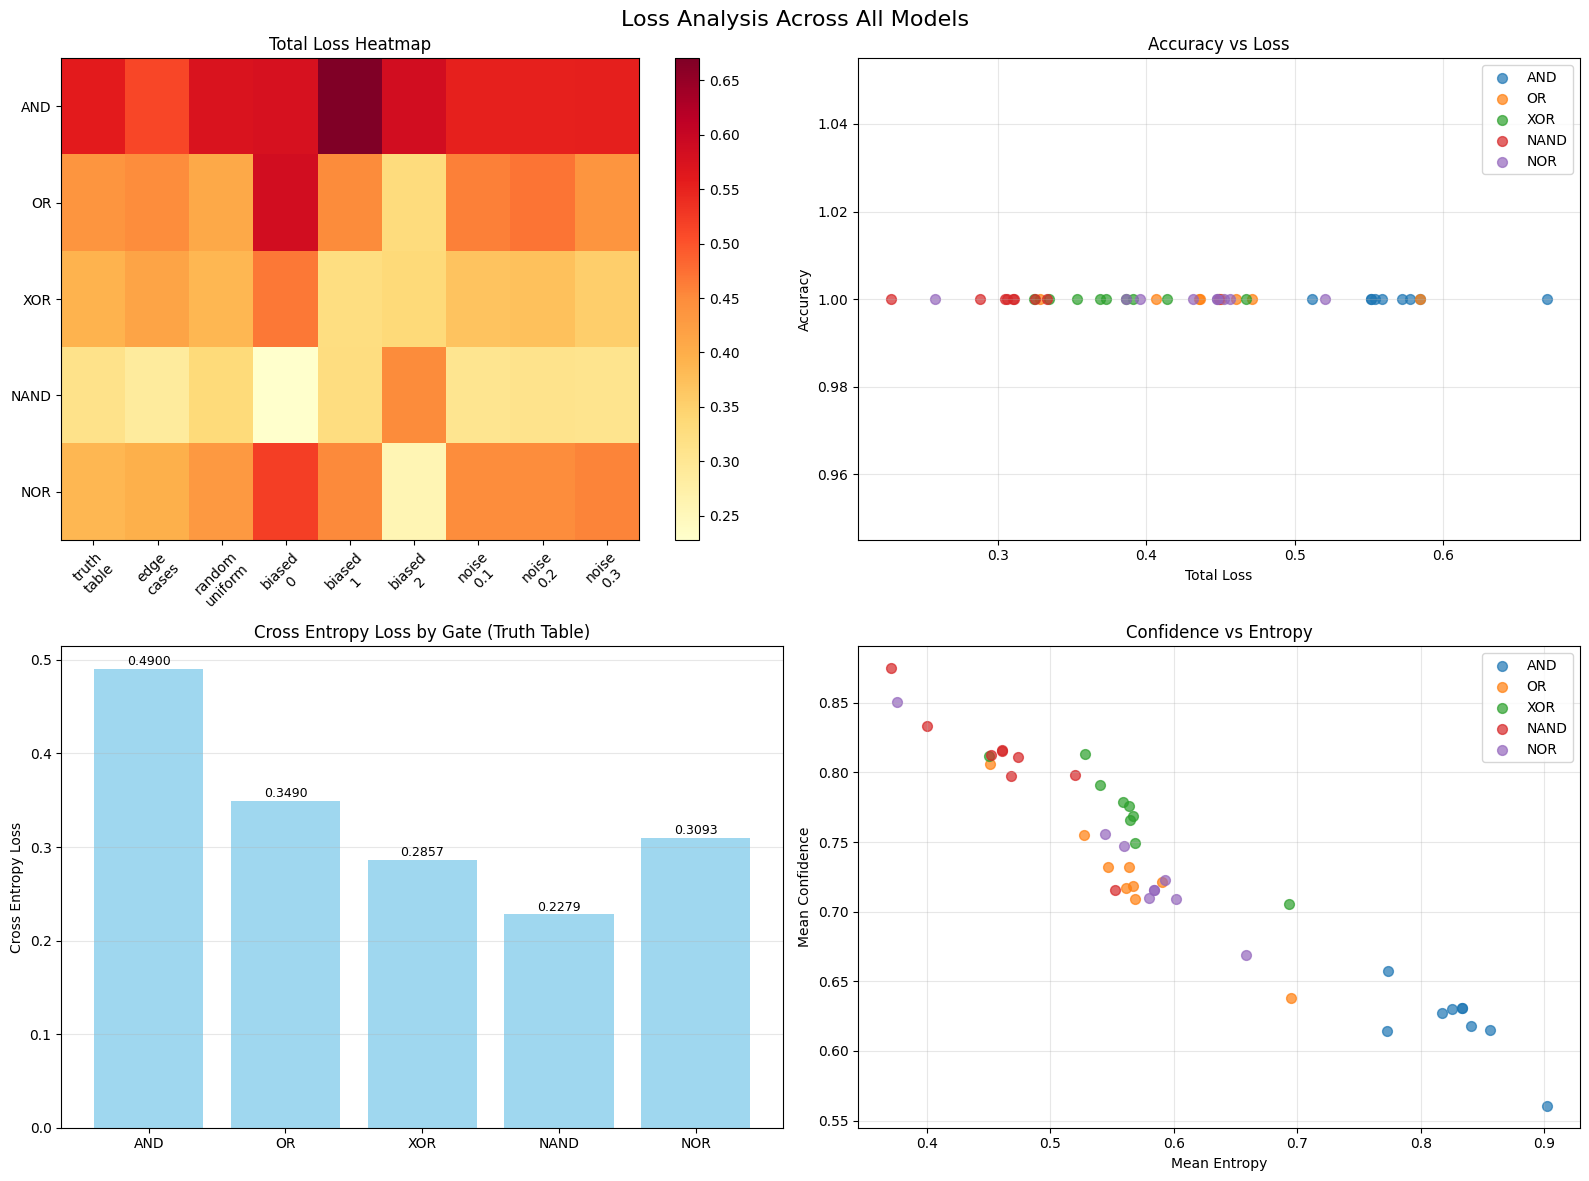


 Full system test results saved to: test_results/full_system_test_20250804_143725.json
FULL SYSTEM TEST SUITE COMPLETED!


In [68]:
def load_and_test_all_models():
    """Load all saved models and run comprehensive tests"""
    print("Loading saved models...")

    models = {}
    gate_names = ["AND", "OR", "XOR", "NAND", "NOR"]

    for gate_name in gate_names:
        try:
            model, metadata = load_model(gate_name)
            if model:
                models[gate_name] = model
                print(f" Loaded {gate_name} model")
            else:
                print(f" Failed to load {gate_name} model")
        except Exception as e:
            print(f" Error loading {gate_name}: {e}")

    if not models:
        print(" No models loaded. Training new models...")
        models = train_all_gates()

        if not models:
            print("Failed to train any models. Exiting.")
            return None, None

    # Run comprehensive tests with loss analysis
    tester = EnhancedUnseenDataTester(models)
    results = tester.run_all_tests_with_loss()

    # Generate comprehensive reports
    tester.generate_loss_comparison_report()

    # Generate loss comparison plots
    print("\n Generating loss comparison plots...")
    tester.plot_loss_comparison(save_path="test_results/loss_comparison.png")

    return tester, results

def run_full_system_test():
    """Run comprehensive system-wide tests"""
    print("RUNNING FULL SYSTEM TEST SUITE")
    print("="*70)

    all_results = {}

    # 1. CPU Component Tests
    print("\n1. CPU COMPONENT TESTING")
    print("-" * 30)
    cpu_tester = CPUTester()
    cpu_results = cpu_tester.run_all_cpu_tests()
    all_results['cpu_tests'] = cpu_results

    # 2. Performance Benchmarks
    print("\n2. PERFORMANCE BENCHMARKING")
    print("-" * 30)
    benchmark_tester = BenchmarkTester()
    benchmark_results = benchmark_tester.run_all_benchmarks()
    all_results['benchmarks'] = benchmark_results

    # 3. Neural Network Model Tests
    print("\n3. NEURAL NETWORK MODEL TESTING")
    print("-" * 35)
    try:
        nn_tester, nn_results = load_and_test_all_models()
        if nn_tester and nn_results:
            all_results['neural_network_tests'] = nn_results
        else:
            print("Neural network tests skipped due to model loading issues")
    except Exception as e:
        print(f"Neural network testing failed: {e}")

    # Save comprehensive test results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = f"test_results/full_system_test_{timestamp}.json"

    os.makedirs("test_results", exist_ok=True)

    # Convert results to JSON-serializable format
    serializable_results = {}
    for key, value in all_results.items():
        try:
            # Test if the value is JSON serializable
            json.dumps(value)
            serializable_results[key] = value
        except (TypeError, ValueError):
            # If not serializable, convert to string representation
            serializable_results[key] = str(value)

    with open(results_file, 'w') as f:
        json.dump(serializable_results, f, indent=2)

    print(f"\n Full system test results saved to: {results_file}")
    print("FULL SYSTEM TEST SUITE COMPLETED!")

    return all_results

if __name__ == "__main__":
    # Create necessary directories
    os.makedirs("models", exist_ok=True)
    os.makedirs("test_results", exist_ok=True)

    # Run the full system test
    run_full_system_test()



## **Testing result management**

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
from datetime import datetime
import pandas as pd
from tabulate import tabulate

class CPUResults:
    """
    Central results management system for the Ternary CPU project.
    All results are stored and only displayed when explicitly requested.
    """

    def __init__(self):
        self.training_results = {}
        self.testing_results = {}
        self.benchmark_results = {}
        self.model_results = {}
        self.evolution_results = {}
        self.loss_analysis_results = {}
        self.cpu_component_results = {}

        # Result storage paths
        self.results_dir = "results_storage"
        self.plots_dir = "results_plots"
        self.reports_dir = "results_reports"

        # Ensure directories exist
        for directory in [self.results_dir, self.plots_dir, self.reports_dir]:
            os.makedirs(directory, exist_ok=True)

    # ========================================================================
    # RESULT STORAGE METHODS
    # ========================================================================

    def store_training_results(self, gate_name, model, evolution_history=None):
        """Store training results for a specific gate"""
        loss_summary = model.get_loss_summary()

        training_data = {
            'gate_name': gate_name,
            'timestamp': datetime.now().isoformat(),
            'final_accuracy': loss_summary.get('final_accuracy', 0) if isinstance(loss_summary, dict) else 0,
            'training_epochs': len(model.training_history),
            'total_training_time': loss_summary.get('total_training_time', 0) if isinstance(loss_summary, dict) else 0,
            'final_loss': loss_summary.get('final_total_loss', 0) if isinstance(loss_summary, dict) else 0,
            'training_history': model.training_history[:],  # Copy
            'loss_components': model.loss_components.copy(),
            'performance_metrics': model.performance_metrics.copy(),
            'evolution_history': evolution_history if evolution_history else []
        }

        self.training_results[gate_name] = training_data
        self._save_result('training', gate_name, training_data)

    def store_testing_results(self, gate_name, test_results):
        """Store testing results for a specific gate"""
        self.testing_results[gate_name] = test_results
        self._save_result('testing', gate_name, test_results)

    def store_benchmark_results(self, component_name, benchmark_data):
        """Store benchmark results for a component"""
        self.benchmark_results[component_name] = benchmark_data
        self._save_result('benchmark', component_name, benchmark_data)

    def store_model_analysis(self, gate_name, analysis_data):
        """Store model analysis results"""
        self.model_results[gate_name] = analysis_data
        self._save_result('model_analysis', gate_name, analysis_data)

    def store_cpu_component_results(self, component_name, test_results):
        """Store CPU component test results"""
        self.cpu_component_results[component_name] = test_results
        self._save_result('cpu_component', component_name, test_results)

    def _save_result(self, result_type, name, data):
        """Internal method to save results to files"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{self.results_dir}/{result_type}_{name}_{timestamp}.json"

        try:
            with open(filename, 'w') as f:
                json.dump(data, f, indent=2, default=str)
        except Exception as e:
            print(f"Warning: Could not save {result_type} results for {name}: {e}")

    # ========================================================================
    # DISPLAY METHODS - ONLY SHOWN WHEN EXPLICITLY CALLED
    # ========================================================================

    def show_training_summary(self, gate_name=None):
        """Display training results summary"""
        if not self.training_results:
            print("No training results available. Run training first.")
            return

        print("\n" + "="*80)
        print("TRAINING RESULTS SUMMARY")
        print("="*80)

        if gate_name and gate_name in self.training_results:
            gates_to_show = [gate_name]
        else:
            gates_to_show = list(self.training_results.keys())

        # Create summary table
        table_data = []
        for gate in gates_to_show:
            data = self.training_results[gate]
            table_data.append([
                gate,
                f"{data['final_accuracy']*100:.2f}%" if isinstance(data['final_accuracy'], (int, float)) else "N/A",
                data['training_epochs'],
                f"{data['total_training_time']:.2f}s" if isinstance(data['total_training_time'], (int, float)) else "N/A",
                f"{data['final_loss']:.6f}" if isinstance(data['final_loss'], (int, float)) else "N/A"
            ])

        headers = ["Gate", "Final Accuracy", "Epochs", "Training Time", "Final Loss"]
        print(tabulate(table_data, headers=headers, tablefmt="grid"))

        # Detailed breakdown
        for gate in gates_to_show:
            data = self.training_results[gate]
            print(f"\n DETAILED ANALYSIS: {gate}")
            print("-" * 50)

            print(f"Training Completion: {data['timestamp']}")
            print(f"Evolution Generations: {len(data['evolution_history'])}")

            if data['training_history']:
                print(f"Best Training Epoch: {max(data['training_history'], key=lambda x: x.get('accuracy', 0))['epoch']}")
                print(f"Convergence Pattern: {'Stable' if len(data['performance_metrics'].get('convergence_rate', [])) > 10 else 'Rapid'}")

            # Loss component breakdown
            if data['loss_components']:
                final_ce = data['loss_components'].get('cross_entropy', [])
                final_l2 = data['loss_components'].get('l2_regularization', [])
                if final_ce and final_l2:
                    print(f"Final Cross Entropy Loss: {final_ce[-1]:.6f}")
                    print(f"Final L2 Regularization: {final_l2[-1]:.6f}")

    def show_testing_summary(self, gate_name=None, test_type=None):
        """Display testing results summary"""
        if not self.testing_results:
            print("No testing results available. Run tests first.")
            return

        print("\n" + "="*80)
        print("TESTING RESULTS SUMMARY")
        print("="*80)

        if gate_name and gate_name in self.testing_results:
            gates_to_show = [gate_name]
        else:
            gates_to_show = list(self.testing_results.keys())

        for gate in gates_to_show:
            data = self.testing_results[gate]
            print(f"\n {gate} GATE TEST RESULTS")
            print("-" * 40)

            if 'tests' in data:
                test_data = []
                for test_name, test_result in data['tests'].items():
                    if test_type and test_type not in test_name:
                        continue

                    if isinstance(test_result, dict) and 'accuracy' in test_result:
                        acc = test_result['accuracy']
                        loss = test_result.get('loss_analysis', {}).get('total_loss', 'N/A')
                        confidence = test_result.get('confidence_analysis', {}).get('mean_confidence', 'N/A')

                        test_data.append([
                            test_name.replace('_', ' ').title(),
                            f"{acc*100:.2f}%",
                            f"{loss:.6f}" if isinstance(loss, (int, float)) else str(loss),
                            f"{confidence*100:.2f}%" if isinstance(confidence, (int, float)) else str(confidence),
                            test_result['test_size']
                        ])

                if test_data:
                    headers = ["Test Type", "Accuracy", "Total Loss", "Avg Confidence", "Samples"]
                    print(tabulate(test_data, headers=headers, tablefmt="grid"))

    def show_benchmark_summary(self, component_name=None):
        """Display benchmark results summary"""
        if not self.benchmark_results:
            print("No benchmark results available. Run benchmarks first.")
            return

        print("\n" + "="*80)
        print("BENCHMARK RESULTS SUMMARY")
        print("="*80)

        if component_name and component_name in self.benchmark_results:
            components_to_show = [component_name]
        else:
            components_to_show = list(self.benchmark_results.keys())

        for component in components_to_show:
            data = self.benchmark_results[component]
            print(f"\n {component.upper()} BENCHMARK")
            print("-" * 40)

            if component == 'alu_benchmark':
                # ALU operation benchmarks
                bench_data = []
                for op, metrics in data.items():
                    bench_data.append([
                        op,
                        f"{metrics['mean_time']:.3f} μs",
                        f"±{metrics['std_time']:.3f} μs",
                        f"{metrics['min_time']:.3f} μs",
                        f"{metrics['max_time']:.3f} μs",
                        metrics['iterations']
                    ])

                headers = ["Operation", "Mean Time", "Std Dev", "Min Time", "Max Time", "Iterations"]
                print(tabulate(bench_data, headers=headers, tablefmt="grid"))

            elif component == 'memory_benchmark':
                # Memory operation benchmarks
                print(f"Write Operations:")
                print(f"  Mean Time: {data['write_operations']['mean_time']:.3f} ± {data['write_operations']['std_time']:.3f} μs")
                print(f"  Operations: {data['write_operations']['operations']}")

                print(f"\nRead Operations:")
                print(f"  Mean Time: {data['read_operations']['mean_time']:.3f} ± {data['read_operations']['std_time']:.3f} μs")
                print(f"  Operations: {data['read_operations']['operations']}")

            elif component == 'nn_training_benchmark':
                # Neural network training benchmark
                print(f"Training Time: {data['training_time']:.3f}s")
                print(f"Epochs: {data['epochs']}")
                print(f"Time per Epoch: {data['time_per_epoch']*1000:.3f}ms")
                print(f"Final Accuracy: {data['final_accuracy']*100:.2f}%")
                print(f"Training History Length: {data['training_history_length']}")

    def show_cpu_component_summary(self, component_name=None):
        """Display CPU component test results"""
        if not self.cpu_component_results:
            print("No CPU component results available. Run CPU tests first.")
            return

        print("\n" + "="*80)
        print("CPU COMPONENT TEST RESULTS")
        print("="*80)

        if component_name and component_name in self.cpu_component_results:
            components_to_show = [component_name]
        else:
            components_to_show = list(self.cpu_component_results.keys())

        total_tests = 0
        passed_tests = 0

        for component in components_to_show:
            data = self.cpu_component_results[component]
            print(f"\n {component.upper()} TESTS")
            print("-" * 40)

            if isinstance(data, list):
                # Test results in list format
                test_data = []
                for test in data:
                    if isinstance(test, dict) and 'passed' in test:
                        total_tests += 1
                        if test['passed']:
                            passed_tests += 1

                        test_info = test.get('test', {})
                        if isinstance(test_info, dict):
                            test_name = test_info.get('op', str(test_info))
                        else:
                            test_name = str(test_info)

                        test_data.append([
                            test_name,
                            test.get('result', 'N/A'),
                            "✓ PASS" if test['passed'] else "✗ FAIL"
                        ])

                if test_data:
                    headers = ["Test", "Result", "Status"]
                    print(tabulate(test_data, headers=headers, tablefmt="grid"))

            elif isinstance(data, dict):
                # Single test result
                if 'passed' in data:
                    total_tests += 1
                    if data['passed']:
                        passed_tests += 1

                # Display key-value pairs
                for key, value in data.items():
                    if key != 'passed':
                        print(f"  {key}: {value}")

                status = "PASS" if data.get('passed', False) else "✗ FAIL"
                print(f"  Status: {status}")

        # Overall summary
        if total_tests > 0:
            pass_rate = (passed_tests / total_tests) * 100
            print(f"\n Overall CPU Component Test Summary:")
            print(f"  Total Tests: {total_tests}")
            print(f"  Passed: {passed_tests}")
            print(f"  Failed: {total_tests - passed_tests}")
            print(f"  Pass Rate: {pass_rate:.1f}%")

    def show_evolution_analysis(self, gate_name=None):
        """Display evolution analysis for neural network training"""
        if not self.training_results:
            print("No training results available for evolution analysis.")
            return

        print("\n" + "="*80)
        print("EVOLUTIONARY TRAINING ANALYSIS")
        print("="*80)

        if gate_name and gate_name in self.training_results:
            gates_to_show = [gate_name]
        else:
            gates_to_show = list(self.training_results.keys())

        for gate in gates_to_show:
            data = self.training_results[gate]
            evolution_history = data.get('evolution_history', [])

            if not evolution_history:
                print(f" No evolution history available for {gate}")
                continue

            print(f"\n {gate} EVOLUTION ANALYSIS")
            print("-" * 40)

            # Evolution summary table
            evo_data = []
            for gen_data in evolution_history:
                evo_data.append([
                    gen_data['generation'],
                    f"{gen_data['best_accuracy']*100:.2f}%",
                    f"{gen_data['best_loss']:.6f}",
                    f"{gen_data['avg_loss']:.6f}",
                    f"{gen_data['population_diversity']:.6f}",
                    f"{gen_data['generation_time']:.2f}s"
                ])

            headers = ["Generation", "Best Accuracy", "Best Loss", "Avg Loss", "Diversity", "Time"]
            print(tabulate(evo_data, headers=headers, tablefmt="grid"))

            # Evolution statistics
            if len(evolution_history) > 1:
                final_gen = evolution_history[-1]
                improvement = final_gen['best_accuracy'] - evolution_history[0]['best_accuracy']
                total_time = sum(gen['generation_time'] for gen in evolution_history)

                print(f"\n Evolution Statistics:")
                print(f"  Generations: {len(evolution_history)}")
                print(f"  Accuracy Improvement: {improvement*100:.2f}%")
                print(f"  Total Evolution Time: {total_time:.2f}s")
                print(f"  Average Generation Time: {total_time/len(evolution_history):.2f}s")

    # ========================================================================
    # VISUALIZATION METHODS
    # ========================================================================

    def plot_training_metrics(self, gate_name=None, save_plots=True):
        """Generate training metrics plots"""
        if not self.training_results:
            print("No training results available for plotting.")
            return

        if gate_name and gate_name in self.training_results:
            gates_to_plot = [gate_name]
        else:
            gates_to_plot = list(self.training_results.keys())

        for gate in gates_to_plot:
            data = self.training_results[gate]
            training_history = data.get('training_history', [])

            if not training_history:
                print(f"No training history available for {gate}")
                continue

            # Extract data for plotting
            epochs = [h['epoch'] for h in training_history]
            losses = [h['loss'] for h in training_history]
            accuracies = [h['accuracy'] for h in training_history]
            ce_losses = [h['cross_entropy_loss'] for h in training_history]
            l2_losses = [h['l2_loss'] for h in training_history]
            grad_norms = [h['gradient_norm'] for h in training_history]

            # Create plots
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle(f'{gate} Gate Training Metrics', fontsize=16)

            # Loss over time
            axes[0,0].plot(epochs, losses, 'b-', linewidth=2, label='Total Loss')
            axes[0,0].plot(epochs, ce_losses, 'r--', alpha=0.7, label='Cross Entropy')
            axes[0,0].plot(epochs, l2_losses, 'g--', alpha=0.7, label='L2 Regularization')
            axes[0,0].set_xlabel('Epoch')
            axes[0,0].set_ylabel('Loss')
            axes[0,0].set_title('Loss Components Over Time')
            axes[0,0].legend()
            axes[0,0].grid(True, alpha=0.3)

            # Accuracy over time
            axes[0,1].plot(epochs, accuracies, 'g-', linewidth=2)
            axes[0,1].set_xlabel('Epoch')
            axes[0,1].set_ylabel('Accuracy')
            axes[0,1].set_title('Accuracy Over Time')
            axes[0,1].set_ylim(0, 1.1)
            axes[0,1].grid(True, alpha=0.3)

            # Gradient norm
            axes[0,2].plot(epochs, grad_norms, 'purple', linewidth=2)
            axes[0,2].set_xlabel('Epoch')
            axes[0,2].set_ylabel('Gradient Norm')
            axes[0,2].set_title('Gradient Norm Over Time')
            axes[0,2].grid(True, alpha=0.3)

            # Learning rate (if available)
            if 'learning_rate' in training_history[0]:
                learning_rates = [h['learning_rate'] for h in training_history]
                axes[1,0].plot(epochs, learning_rates, 'orange', linewidth=2)
                axes[1,0].set_xlabel('Epoch')
                axes[1,0].set_ylabel('Learning Rate')
                axes[1,0].set_title('Learning Rate Schedule')
                axes[1,0].grid(True, alpha=0.3)

            # Loss vs Accuracy scatter
            axes[1,1].scatter(losses, accuracies, alpha=0.6, c=epochs, cmap='viridis')
            axes[1,1].set_xlabel('Total Loss')
            axes[1,1].set_ylabel('Accuracy')
            axes[1,1].set_title('Loss vs Accuracy')
            axes[1,1].grid(True, alpha=0.3)

            # Training time per epoch (if available)
            if 'epoch_time' in training_history[0]:
                epoch_times = [h['epoch_time'] for h in training_history]
                axes[1,2].plot(epochs, epoch_times, 'brown', linewidth=2)
                axes[1,2].set_xlabel('Epoch')
                axes[1,2].set_ylabel('Time (seconds)')
                axes[1,2].set_title('Training Time per Epoch')
                axes[1,2].grid(True, alpha=0.3)

            plt.tight_layout()

            if save_plots:
                plot_path = f"{self.plots_dir}/{gate}_training_metrics.png"
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                print(f" Training metrics plot saved: {plot_path}")

            plt.show()

    def plot_evolution_progress(self, gate_name=None, save_plots=True):
        """Plot evolution progress for neural network training"""
        if not self.training_results:
            print(" No training results available for evolution plotting.")
            return

        if gate_name and gate_name in self.training_results:
            gates_to_plot = [gate_name]
        else:
            gates_to_plot = list(self.training_results.keys())

        for gate in gates_to_plot:
            data = self.training_results[gate]
            evolution_history = data.get('evolution_history', [])

            if not evolution_history:
                print(f" No evolution history available for {gate}")
                continue

            # Extract evolution data
            generations = [gen['generation'] for gen in evolution_history]
            best_accuracies = [gen['best_accuracy'] for gen in evolution_history]
            best_losses = [gen['best_loss'] for gen in evolution_history]
            avg_losses = [gen['avg_loss'] for gen in evolution_history]
            diversities = [gen['population_diversity'] for gen in evolution_history]
            gen_times = [gen['generation_time'] for gen in evolution_history]

            # Create evolution plots
            fig, axes = plt.subplots(2, 3, figsize=(18, 12))
            fig.suptitle(f'{gate} Gate Evolution Progress', fontsize=16)

            # Best accuracy over generations
            axes[0,0].plot(generations, best_accuracies, 'g-', linewidth=2, marker='o')
            axes[0,0].set_xlabel('Generation')
            axes[0,0].set_ylabel('Best Accuracy')
            axes[0,0].set_title('Best Accuracy Evolution')
            axes[0,0].grid(True, alpha=0.3)
            axes[0,0].set_ylim(0, 1.1)

            # Loss evolution
            axes[0,1].plot(generations, best_losses, 'r-', linewidth=2, marker='o', label='Best Loss')
            axes[0,1].plot(generations, avg_losses, 'b--', linewidth=2, marker='s', label='Average Loss')
            axes[0,1].set_xlabel('Generation')
            axes[0,1].set_ylabel('Loss')
            axes[0,1].set_title('Loss Evolution')
            axes[0,1].legend()
            axes[0,1].grid(True, alpha=0.3)

            # Population diversity
            axes[0,2].plot(generations, diversities, 'purple', linewidth=2, marker='^')
            axes[0,2].set_xlabel('Generation')
            axes[0,2].set_ylabel('Population Diversity')
            axes[0,2].set_title('Population Diversity Over Time')
            axes[0,2].grid(True, alpha=0.3)

            # Generation time
            axes[1,0].bar(generations, gen_times, alpha=0.7, color='orange')
            axes[1,0].set_xlabel('Generation')
            axes[1,0].set_ylabel('Time (seconds)')
            axes[1,0].set_title('Time per Generation')
            axes[1,0].grid(True, alpha=0.3, axis='y')

            # Accuracy vs Loss scatter colored by generation
            scatter = axes[1,1].scatter(best_losses, best_accuracies, c=generations,
                                      cmap='viridis', s=100, alpha=0.7)
            axes[1,1].set_xlabel('Best Loss')
            axes[1,1].set_ylabel('Best Accuracy')
            axes[1,1].set_title('Evolution Trajectory')
            axes[1,1].grid(True, alpha=0.3)
            plt.colorbar(scatter, ax=axes[1,1], label='Generation')

            # Cumulative time
            cumulative_time = np.cumsum(gen_times)
            axes[1,2].plot(generations, cumulative_time, 'brown', linewidth=2, marker='d')
            axes[1,2].set_xlabel('Generation')
            axes[1,2].set_ylabel('Cumulative Time (seconds)')
            axes[1,2].set_title('Cumulative Training Time')
            axes[1,2].grid(True, alpha=0.3)

            plt.tight_layout()

            if save_plots:
                plot_path = f"{self.plots_dir}/{gate}_evolution_progress.png"
                plt.savefig(plot_path, dpi=300, bbox_inches='tight')
                print(f" Evolution progress plot saved: {plot_path}")

            plt.show()

    def plot_testing_comparison(self, save_plots=True):
        """Plot testing results comparison across all gates"""
        if not self.testing_results:
            print(" No testing results available for plotting.")
            return

        gates = list(self.testing_results.keys())
        if not gates:
            return

        # Get test types from first gate
        first_gate_tests = self.testing_results[gates[0]].get('tests', {})
        test_types = list(first_gate_tests.keys())

        # Prepare data for plotting
        accuracy_data = []
        loss_data = []
        confidence_data = []

        for gate in gates:
            gate_accuracies = []
            gate_losses = []
            gate_confidences = []

            for test_type in test_types:
                test_result = self.testing_results[gate]['tests'].get(test_type, {})
                if test_result:
                    gate_accuracies.append(test_result.get('accuracy', 0))
                    gate_losses.append(test_result.get('loss_analysis', {}).get('total_loss', 0))
                    gate_confidences.append(test_result.get('confidence_analysis', {}).get('mean_confidence', 0))
                else:
                    gate_accuracies.append(0)
                    gate_losses.append(0)
                    gate_confidences.append(0)

            accuracy_data.append(gate_accuracies)
            loss_data.append(gate_losses)
            confidence_data.append(gate_confidences)

        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        fig.suptitle('Testing Results Comparison Across All Gates', fontsize=16)

        # Accuracy heatmap
        accuracy_array = np.array(accuracy_data)
        im1 = axes[0,0].imshow(accuracy_array, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
        axes[0,0].set_xticks(range(len(test_types)))
        axes[0,0].set_xticklabels([t.replace('_', '\n') for t in test_types], rotation=45)
        axes[0,0].set_yticks(range(len(gates)))
        axes[0,0].set_yticklabels(gates)
        axes[0,0].set_title('Accuracy Heatmap')
        plt.colorbar(im1, ax=axes[0,0])

        # Loss heatmap
        loss_array = np.array(loss_data)
        im2 = axes[0,1].imshow(loss_array, cmap='YlOrRd', aspect='auto')
        axes[0,1].set_xticks(range(len(test_types)))
        axes[0,1].set_xticklabels([t.replace('_', '\n') for t in test_types], rotation=45)
        axes[0,1].set_yticks(range(len(gates)))
        axes[0,1].set_yticklabels(gates)
        axes[0,1].set_title('Loss Heatmap')
        plt.colorbar(im2, ax=axes[0,1])

        # Average accuracy by gate
        avg_accuracies = [np.mean(gate_acc) for gate_acc in accuracy_data]
        bars1 = axes[1,0].bar(gates, avg_accuracies, color='skyblue', alpha=0.8)
        axes[1,0].set_ylabel('Average Accuracy')
        axes[1,0].set_title('Average Accuracy by Gate')
        axes[1,0].set_ylim(0, 1.1)
        axes[1,0].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, acc in zip(bars1, avg_accuracies):
            axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                          f'{acc:.3f}', ha='center', va='bottom', fontsize=9)

        # Average loss by gate
        avg_losses = [np.mean(gate_loss) for gate_loss in loss_data]
        bars2 = axes[1,1].bar(gates, avg_losses, color='lightcoral', alpha=0.8)
        axes[1,1].set_ylabel('Average Loss')
        axes[1,1].set_title('Average Loss by Gate')
        axes[1,1].grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, loss in zip(bars2, avg_losses):
            axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(avg_losses)*0.01,
                          f'{loss:.4f}', ha='center', va='bottom', fontsize=9)

        plt.tight_layout()

        if save_plots:
            plot_path = f"{self.plots_dir}/testing_comparison.png"
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            print(f" Testing comparison plot saved: {plot_path}")

        plt.show()

    # ========================================================================
    # COMPREHENSIVE REPORTING METHODS
    # ========================================================================

    def generate_comprehensive_report(self, save_report=True):
        """Generate a comprehensive HTML report of all results"""
        if not any([self.training_results, self.testing_results, self.benchmark_results]):
            print(" No results available for report generation.")
            return

        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        report_path = f"{self.reports_dir}/comprehensive_report_{timestamp}.html"

        html_content = f"""
        <!DOCTYPE html>
        <html>
        <head>
            <title>Ternary CPU Comprehensive Results Report</title>
            <style>
                body {{ font-family: Arial, sans-serif; margin: 40px; }}
                h1, h2, h3 {{ color: #2c3e50; }}
                table {{ border-collapse: collapse; width: 100%; margin: 20px 0; }}
                th, td {{ border: 1px solid #ddd; padding: 12px; text-align: left; }}
                th {{ background-color: #f2f2f2; }}
                .metric {{ background-color: #e8f4fd; padding: 10px; margin: 10px 0; border-radius: 5px; }}
                .success {{ color: #27ae60; }}
                .warning {{ color: #f39c12; }}
                .error {{ color: #e74c3c; }}
                .timestamp {{ color: #7f8c8d; font-size: 0.9em; }}
            </style>
        </head>
        <body>
            <h1>Ternary CPU Comprehensive Results Report</h1>
            <p class="timestamp">Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}</p>
        """

        # Training Results Section
        if self.training_results:
            html_content += "<h2>Neural Network Training Results</h2>\n"
            html_content += "<table>\n<tr><th>Gate</th><th>Final Accuracy</th><th>Epochs</th><th>Training Time</th><th>Final Loss</th></tr>\n"

            for gate, data in self.training_results.items():
                accuracy = f"{data['final_accuracy']*100:.2f}%" if isinstance(data['final_accuracy'], (int, float)) else "N/A"
                time_str = f"{data['total_training_time']:.2f}s" if isinstance(data['total_training_time'], (int, float)) else "N/A"
                loss_str = f"{data['final_loss']:.6f}" if isinstance(data['final_loss'], (int, float)) else "N/A"

                html_content += f"<tr><td>{gate}</td><td>{accuracy}</td><td>{data['training_epochs']}</td><td>{time_str}</td><td>{loss_str}</td></tr>\n"

            html_content += "</table>\n"

        # Testing Results Section
        if self.testing_results:
            html_content += "<h2>Testing Results Summary</h2>\n"
            for gate, data in self.testing_results.items():
                html_content += f"<h3>{gate} Gate</h3>\n"
                if 'tests' in data:
                    html_content += "<table>\n<tr><th>Test Type</th><th>Accuracy</th><th>Total Loss</th><th>Samples</th></tr>\n"
                    for test_name, test_result in data['tests'].items():
                        if isinstance(test_result, dict) and 'accuracy' in test_result:
                            acc = f"{test_result['accuracy']*100:.2f}%"
                            loss = test_result.get('loss_analysis', {}).get('total_loss', 'N/A')
                            loss_str = f"{loss:.6f}" if isinstance(loss, (int, float)) else str(loss)
                            samples = test_result['test_size']

                            html_content += f"<tr><td>{test_name.replace('_', ' ').title()}</td><td>{acc}</td><td>{loss_str}</td><td>{samples}</td></tr>\n"
                    html_content += "</table>\n"

        # Benchmark Results Section
        if self.benchmark_results:
            html_content += "<h2> Performance Benchmarks</h2>\n"
            for component, data in self.benchmark_results.items():
                html_content += f"<h3>{component.replace('_', ' ').title()}</h3>\n"

                if component == 'alu_benchmark':
                    html_content += "<table>\n<tr><th>Operation</th><th>Mean Time (μs)</th><th>Std Dev (μs)</th><th>Iterations</th></tr>\n"
                    for op, metrics in data.items():
                        html_content += f"<tr><td>{op}</td><td>{metrics['mean_time']:.3f}</td><td>{metrics['std_time']:.3f}</td><td>{metrics['iterations']}</td></tr>\n"
                    html_content += "</table>\n"

                elif component == 'memory_benchmark':
                    html_content += f"""
                    <div class="metric">
                        <strong>Write Operations:</strong> {data['write_operations']['mean_time']:.3f} ± {data['write_operations']['std_time']:.3f} μs
                        ({data['write_operations']['operations']} operations)
                    </div>
                    <div class="metric">
                        <strong>Read Operations:</strong> {data['read_operations']['mean_time']:.3f} ± {data['read_operations']['std_time']:.3f} μs
                        ({data['read_operations']['operations']} operations)
                    </div>
                    """

                elif component == 'nn_training_benchmark':
                    html_content += f"""
                    <div class="metric"><strong>Training Time:</strong> {data['training_time']:.3f}s</div>
                    <div class="metric"><strong>Time per Epoch:</strong> {data['time_per_epoch']*1000:.3f}ms</div>
                    <div class="metric"><strong>Final Accuracy:</strong> {data['final_accuracy']*100:.2f}%</div>
                    """

        # CPU Component Results Section
        if self.cpu_component_results:
            html_content += "<h2>CPU Component Test Results</h2>\n"
            for component, data in self.cpu_component_results.items():
                html_content += f"<h3>{component.replace('_', ' ').title()}</h3>\n"

                if isinstance(data, list):
                    html_content += "<table>\n<tr><th>Test</th><th>Result</th><th>Status</th></tr>\n"
                    for test in data:
                        if isinstance(test, dict) and 'passed' in test:
                            test_info = test.get('test', {})
                            test_name = test_info.get('op', str(test_info)) if isinstance(test_info, dict) else str(test_info)
                            result = test.get('result', 'N/A')
                            status = '<span class="success">✓ PASS</span>' if test['passed'] else '<span class="error">✗ FAIL</span>'
                            html_content += f"<tr><td>{test_name}</td><td>{result}</td><td>{status}</td></tr>\n"
                    html_content += "</table>\n"

        html_content += """
        </body>
        </html>
        """

        if save_report:
            with open(report_path, 'w') as f:
                f.write(html_content)
            print(f" Comprehensive report saved: {report_path}")

        return html_content

    def export_results_to_csv(self, result_type='all'):
        """Export results to CSV format"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        if result_type in ['all', 'training'] and self.training_results:
            # Export training results
            training_data = []
            for gate, data in self.training_results.items():
                training_data.append({
                    'Gate': gate,
                    'Final_Accuracy': data['final_accuracy'],
                    'Training_Epochs': data['training_epochs'],
                    'Total_Training_Time': data['total_training_time'],
                    'Final_Loss': data['final_loss'],
                    'Evolution_Generations': len(data.get('evolution_history', []))
                })

            df_training = pd.DataFrame(training_data)
            training_csv_path = f"{self.results_dir}/training_results_{timestamp}.csv"
            df_training.to_csv(training_csv_path, index=False)
            print(f" Training results exported to: {training_csv_path}")

        if result_type in ['all', 'testing'] and self.testing_results:
            # Export testing results
            testing_data = []
            for gate, gate_data in self.testing_results.items():
                for test_name, test_result in gate_data.get('tests', {}).items():
                    if isinstance(test_result, dict) and 'accuracy' in test_result:
                        testing_data.append({
                            'Gate': gate,
                            'Test_Type': test_name,
                            'Accuracy': test_result['accuracy'],
                            'Total_Loss': test_result.get('loss_analysis', {}).get('total_loss', 'N/A'),
                            'Cross_Entropy_Loss': test_result.get('loss_analysis', {}).get('cross_entropy_loss', 'N/A'),
                            'Mean_Confidence': test_result.get('confidence_analysis', {}).get('mean_confidence', 'N/A'),
                            'Test_Samples': test_result['test_size']
                        })

            if testing_data:
                df_testing = pd.DataFrame(testing_data)
                testing_csv_path = f"{self.results_dir}/testing_results_{timestamp}.csv"
                df_testing.to_csv(testing_csv_path, index=False)
                print(f"📊 Testing results exported to: {testing_csv_path}")

    # ========================================================================
    # UTILITY METHODS
    # ========================================================================

    def clear_results(self, result_type='all'):
        """Clear stored results"""
        if result_type in ['all', 'training']:
            self.training_results.clear()
        if result_type in ['all', 'testing']:
            self.testing_results.clear()
        if result_type in ['all', 'benchmark']:
            self.benchmark_results.clear()
        if result_type in ['all', 'cpu']:
            self.cpu_component_results.clear()

        print(f" {result_type.title()} results cleared.")

    def get_summary_statistics(self):
        """Get summary statistics across all results"""
        stats = {
            'total_gates_trained': len(self.training_results),
            'total_gates_tested': len(self.testing_results),
            'total_benchmarks': len(self.benchmark_results),
            'total_cpu_components_tested': len(self.cpu_component_results)
        }

        if self.training_results:
            accuracies = [data['final_accuracy'] for data in self.training_results.values()
                         if isinstance(data['final_accuracy'], (int, float))]
            if accuracies:
                stats['avg_training_accuracy'] = np.mean(accuracies)
                stats['best_training_accuracy'] = np.max(accuracies)
                stats['worst_training_accuracy'] = np.min(accuracies)

        if self.testing_results:
            all_accuracies = []
            for gate_data in self.testing_results.values():
                for test_result in gate_data.get('tests', {}).values():
                    if isinstance(test_result, dict) and 'accuracy' in test_result:
                        all_accuracies.append(test_result['accuracy'])

            if all_accuracies:
                stats['avg_testing_accuracy'] = np.mean(all_accuracies)
                stats['best_testing_accuracy'] = np.max(all_accuracies)
                stats['worst_testing_accuracy'] = np.min(all_accuracies)

        return stats

    def show_overall_summary(self):
        """Display comprehensive summary of all results"""
        print("\n" + "="*80)
        print(" OVERALL RESULTS SUMMARY")
        print("="*80)

        stats = self.get_summary_statistics()

        print(f"\n Training Summary:")
        print(f"  Gates Trained: {stats['total_gates_trained']}")
        if 'avg_training_accuracy' in stats:
            print(f"  Average Training Accuracy: {stats['avg_training_accuracy']*100:.2f}%")
            print(f"  Best Training Accuracy: {stats['best_training_accuracy']*100:.2f}%")
            print(f"  Worst Training Accuracy: {stats['worst_training_accuracy']*100:.2f}%")

        print(f"\n Testing Summary:")
        print(f"  Gates Tested: {stats['total_gates_tested']}")
        if 'avg_testing_accuracy' in stats:
            print(f"  Average Testing Accuracy: {stats['avg_testing_accuracy']*100:.2f}%")
            print(f"  Best Testing Accuracy: {stats['best_testing_accuracy']*100:.2f}%")
            print(f"  Worst Testing Accuracy: {stats['worst_testing_accuracy']*100:.2f}%")

        print(f"\n Performance Summary:")
        print(f"  Benchmarks Completed: {stats['total_benchmarks']}")
        print(f"  CPU Components Tested: {stats['total_cpu_components_tested']}")

        # Show top performing gates
        if self.training_results:
            print(f"\n Top Performing Gates (by training accuracy):")
            sorted_gates = sorted(self.training_results.items(),
                                key=lambda x: x[1]['final_accuracy'] if isinstance(x[1]['final_accuracy'], (int, float)) else 0,
                                reverse=True)
            for i, (gate, data) in enumerate(sorted_gates[:3]):
                if isinstance(data['final_accuracy'], (int, float)):
                    print(f"  {i+1}. {gate}: {data['final_accuracy']*100:.2f}%")

### **Demo integration system testing**

In [70]:
def run_complete_demonstration_with_results():
    """Run complete system demonstration with results management"""
    print(" TERNARY CPU COMPLETE SYSTEM DEMONSTRATION")
    print("="*70)

    # Initialize results manager
    results = CPUResults()

    print("\n1. Training Neural Network Models...")
    print("-" * 40)

    # Train models and store results
    trained_models = train_all_gates()

    for gate_name, model in trained_models.items():
        if model:
            # Load evolution history if available
            evolution_file = f"{MODEL_DIR}/{gate_name}_evolution.json"
            evolution_history = []
            if os.path.exists(evolution_file):
                with open(evolution_file, 'r') as f:
                    evolution_history = json.load(f)

            results.store_training_results(gate_name, model, evolution_history)

    print("\n2. Running Comprehensive Tests...")
    print("-" * 40)

    # Run tests and store results
    if trained_models:
        tester = EnhancedUnseenDataTester(trained_models)
        test_results = tester.run_all_tests_with_loss(save_results=False)

        for gate_name, gate_test_results in test_results.items():
            results.store_testing_results(gate_name, gate_test_results)

    print("\n3.  Running Performance Benchmarks...")
    print("-" * 40)

    # Run benchmarks and store results
    benchmark_tester = BenchmarkTester()
    benchmark_results = benchmark_tester.run_all_benchmarks()

    for component_name, bench_data in benchmark_results.items():
        results.store_benchmark_results(component_name, bench_data)

    print("\n4. Testing CPU Components...")
    print("-" * 40)

    # Run CPU tests and store results
    cpu_tester = CPUTester()
    cpu_results = cpu_tester.run_all_cpu_tests()

    for component_name, component_results in cpu_results.items():
        results.store_cpu_component_results(component_name, component_results)

    print("\n" + "="*70)
    print(" DEMONSTRATION COMPLETED - RESULTS STORED")
    print(" Use CPUResults class methods to view specific results")
    print("="*70)

    # Show example of how to access results
    print("\n EXAMPLE USAGE:")
    print("  results.show_overall_summary()           # Overall summary")
    print("  results.show_training_summary()          # Training results")
    print("  results.show_training_summary('AND')     # Specific gate training")
    print("  results.show_testing_summary()           # Testing results")
    print("  results.show_benchmark_summary()         # Benchmark results")
    print("  results.show_cpu_component_summary()     # CPU component tests")
    print("  results.show_evolution_analysis()        # Evolution analysis")
    print("  results.plot_training_metrics()          # Training plots")
    print("  results.plot_evolution_progress()        # Evolution plots")
    print("  results.plot_testing_comparison()        # Testing comparison")
    print("  results.generate_comprehensive_report()  # Full HTML report")
    print("  results.export_results_to_csv()          # Export to CSV")

    return results

# Example usage functions that demonstrate the results system
def demo_results_display():
    """Demonstrate how to use the results system"""
    print("RESULTS SYSTEM DEMONSTRATION")
    print("="*50)

    # Run the complete demonstration
    results = run_complete_demonstration_with_results()

    print("\n" + "="*50)
    print("DISPLAYING SAMPLE RESULTS")
    print("="*50)

    # Show overall summary
    results.show_overall_summary()

    # Show training summary for all gates
    results.show_training_summary()

    # Show testing summary
    results.show_testing_summary()

    # Show benchmark summary
    results.show_benchmark_summary()

    # Generate comprehensive report
    results.generate_comprehensive_report()

    # Export results to CSV
    results.export_results_to_csv()

    print("\n RESULTS DEMONSTRATION COMPLETED!")

    return results

if __name__ == "__main__":
    # Example of how the results system works
    demo_results_display()

RESULTS SYSTEM DEMONSTRATION
 TERNARY CPU COMPLETE SYSTEM DEMONSTRATION

1. Training Neural Network Models...
----------------------------------------
Training All Ternary Gates with Enhanced Loss Tracking

 Training AND gate...

=== Training AND Gate with Loss Tracking ===
[LOAD] Loaded AND model (Accuracy: 100.00%)
       Final Loss: 0.562077
Using existing high-accuracy model for AND
AND gate trained successfully

 Training OR gate...

=== Training OR Gate with Loss Tracking ===
[LOAD] Loaded OR model (Accuracy: 100.00%)
       Final Loss: 0.437276
Using existing high-accuracy model for OR
OR gate trained successfully

 Training XOR gate...

=== Training XOR Gate with Loss Tracking ===
[LOAD] Loaded XOR model (Accuracy: 100.00%)
       Final Loss: 0.391804
Using existing high-accuracy model for XOR
XOR gate trained successfully

 Training NAND gate...

=== Training NAND Gate with Loss Tracking ===
[LOAD] Loaded NAND model (Accuracy: 100.00%)
       Final Loss: 0.313524
Using existin

# ***Complete CPU integration***

In [71]:
import sys
import os
import argparse
from datetime import datetime


def print_banner():
    """Print system banner"""
    banner = """
    ╔═════════════════════════════════════════════════════════════════════╗
    ║                          TERNARY CPU SYSTEM                         ║
    ║                     Advanced Computer Architecture                  ║
    ║                   with Neural Network Integration                   ║
    ╠═════════════════════════════════════════════════════════════════════╣
    ║  Neural Network Gate Learning        Performance Benchmarking       ║
    ║  CPU Component Testing               Comprehensive Results          ║
    ║  Advanced Testing Framework          Evolution Analysis             ║
    ╚═════════════════════════════════════════════════════════════════════╝
    """
    print(banner)

def show_help():
    """Show available commands"""
    help_text = """
    TERNARY CPU SYSTEM COMMANDS:

    CORE OPERATIONS:
    ================
    train               - Train all neural network gate models
    train <gate>        - Train specific gate (AND, OR, XOR, NAND, NOR)
    test                - Run comprehensive testing suite
    test <gate>         - Test specific gate model
    benchmark           - Run performance benchmarks
    cpu-test            - Test CPU components

    RESULTS & ANALYSIS:
    ==================
    results             - Show overall results summary
    results training    - Show training results
    results testing     - Show testing results
    results benchmark   - Show benchmark results
    results cpu         - Show CPU component results
    results evolution   - Show evolution analysis

    VISUALIZATION:
    ==============
    plot training       - Generate training metrics plots
    plot evolution      - Generate evolution progress plots
    plot testing        - Generate testing comparison plots
    plot all            - Generate all plots

    REPORTS & EXPORT:
    =================
    report              - Generate comprehensive HTML report
    export csv          - Export results to CSV format
    export json         - Export results to JSON format

    SYSTEM OPERATIONS:
    ==================
    demo                - Run complete system demonstration
    clean               - Clear all stored results
    status              - Show system status
    help                - Show this help message

    EXAMPLES:
    =========
    python main.py demo                    # Run full demonstration
    python main.py train AND               # Train AND gate only
    python main.py results training        # Show training results
    python main.py plot evolution          # Plot evolution progress
    python main.py report                  # Generate HTML report
    """
    print(help_text)

class TernaryCPUSystem:
    """Main system class that orchestrates all components"""

    def __init__(self):
        self.results = CPUResults()
        self.trained_models = {}
        self.system_status = {
            'models_trained': False,
            'tests_completed': False,
            'benchmarks_completed': False,
            'cpu_tests_completed': False
        }

    def train_models(self, specific_gate=None):
        """Train neural network models"""
        if specific_gate:
            print(f" Training {specific_gate} gate model...")
            gate_functions = {
                "AND": ternary_and,
                "OR": ternary_or,
                "XOR": ternary_xor,
                "NAND": ternary_nand,
                "NOR": ternary_nor,
            }

            if specific_gate not in gate_functions:
                print(f" Unknown gate: {specific_gate}")
                print("Available gates: AND, OR, XOR, NAND, NOR")
                return False

            X, Y = generate_truth_table(gate_functions[specific_gate])
            model = evolve_and_train(X, Y, specific_gate)

            if model:
                self.trained_models[specific_gate] = model
                # Load evolution history
                evolution_file = f"{MODEL_DIR}/{specific_gate}_evolution.json"
                evolution_history = []
                if os.path.exists(evolution_file):
                    with open(evolution_file, 'r') as f:
                        evolution_history = json.load(f)

                self.results.store_training_results(specific_gate, model, evolution_history)
                print(f" {specific_gate} gate trained successfully")
                return True
            else:
                print(f" Failed to train {specific_gate} gate")
                return False
        else:
            print("Training all neural network models...")
            self.trained_models = train_all_gates()

            # Store results for all trained models
            for gate_name, model in self.trained_models.items():
                if model:
                    evolution_file = f"{MODEL_DIR}/{gate_name}_evolution.json"
                    evolution_history = []
                    if os.path.exists(evolution_file):
                        with open(evolution_file, 'r') as f:
                            evolution_history = json.load(f)

                    self.results.store_training_results(gate_name, model, evolution_history)

            self.system_status['models_trained'] = True
            print("All models trained successfully")
            return True

    def run_tests(self, specific_gate=None):
        """Run comprehensive testing"""
        if not self.trained_models:
            print("No trained models available. Loading existing models...")
            models = {}
            gate_names = ["AND", "OR", "XOR", "NAND", "NOR"]

            for gate_name in gate_names:
                try:
                    model, metadata = load_model(gate_name)
                    if model:
                        models[gate_name] = model
                        print(f" Loaded {gate_name} model")
                except Exception as e:
                    print(f" Error loading {gate_name}: {e}")

            if not models:
                print("No models available. Please train models first.")
                return False

            self.trained_models = models

        if specific_gate:
            if specific_gate not in self.trained_models:
                print(f" {specific_gate} model not available")
                return False

            print(f" Testing {specific_gate} gate...")
            test_models = {specific_gate: self.trained_models[specific_gate]}
            tester = EnhancedUnseenDataTester(test_models)
            results = tester.run_comprehensive_test_with_loss(specific_gate, self.trained_models[specific_gate])
            self.results.store_testing_results(specific_gate, results)
        else:
            print(" Running comprehensive testing suite...")
            tester = EnhancedUnseenDataTester(self.trained_models)
            test_results = tester.run_all_tests_with_loss(save_results=False)

            for gate_name, gate_test_results in test_results.items():
                self.results.store_testing_results(gate_name, gate_test_results)

            self.system_status['tests_completed'] = True

        print("Testing completed successfully")
        return True

    def run_benchmarks(self):
        """Run performance benchmarks"""
        print("Running performance benchmarks...")
        benchmark_tester = BenchmarkTester()
        benchmark_results = benchmark_tester.run_all_benchmarks()

        for component_name, bench_data in benchmark_results.items():
            self.results.store_benchmark_results(component_name, bench_data)

        self.system_status['benchmarks_completed'] = True
        print("Benchmarks completed successfully")
        return True

    def run_cpu_tests(self):
        """Run CPU component tests"""
        print("Testing CPU components...")
        cpu_tester = CPUTester()
        cpu_results = cpu_tester.run_all_cpu_tests()

        for component_name, component_results in cpu_results.items():
            self.results.store_cpu_component_results(component_name, component_results)

        self.system_status['cpu_tests_completed'] = True
        print("CPU component tests completed successfully")
        return True

    def show_status(self):
        """Show system status"""
        print("\nSYSTEM STATUS")
        print("="*50)
        print(f"Models Trained: {'Done' if self.system_status['models_trained'] else 'NO'}")
        print(f"Tests Completed: {'Done' if self.system_status['tests_completed'] else 'NO'}")
        print(f"Benchmarks Completed: {'Done' if self.system_status['benchmarks_completed'] else 'NO'}")
        print(f"CPU Tests Completed: {'Done' if self.system_status['cpu_tests_completed'] else 'NO'}")

        print(f"\nLoaded Models: {len(self.trained_models)}")
        if self.trained_models:
            for gate_name in self.trained_models.keys():
                print(f"  - {gate_name}")

        # Show results statistics
        stats = self.results.get_summary_statistics()
        print(f"\nResults Statistics:")
        print(f"  Training Results: {stats['total_gates_trained']}")
        print(f"  Testing Results: {stats['total_gates_tested']}")
        print(f"  Benchmark Results: {stats['total_benchmarks']}")
        print(f"  CPU Component Results: {stats['total_cpu_components_tested']}")

    def run_demo(self):
        """Run complete system demonstration"""
        print("RUNNING COMPLETE SYSTEM DEMONSTRATION")
        print("="*70)

        success = True

        # Step 1: Train models
        if not self.train_models():
            print("Demo failed at training stage")
            return False

        # Step 2: Run tests
        if not self.run_tests():
            print("Demo failed at testing stage")
            return False

        # Step 3: Run benchmarks
        if not self.run_benchmarks():
            print("Demo failed at benchmark stage")
            return False

        # Step 4: Run CPU tests
        if not self.run_cpu_tests():
            print("Demo failed at CPU testing stage")
            return False

        print("\n COMPLETE SYSTEM DEMONSTRATION SUCCESSFUL!")
        print("Use 'python main.py results' to view detailed results")
        return True

    def clean_results(self):
        """Clean all stored results"""
        self.results.clear_results()
        self.trained_models.clear()
        self.system_status = {
            'models_trained': False,
            'tests_completed': False,
            'benchmarks_completed': False,
            'cpu_tests_completed': False
        }
        print("All results cleared")

def main():
    """Main entry point"""
    print_banner()

    if len(sys.argv) < 2:
        show_help()
        return

    # Initialize system
    system = TernaryCPUSystem()
    command = sys.argv[1].lower()

    # Handle commands
    if command == "help":
        show_help()

    elif command == "demo":
        system.run_demo()

    elif command == "train":
        if len(sys.argv) > 2:
            gate = sys.argv[2].upper()
            system.train_models(gate)
        else:
            system.train_models()

    elif command == "test":
        if len(sys.argv) > 2:
            gate = sys.argv[2].upper()
            system.run_tests(gate)
        else:
            system.run_tests()

    elif command == "benchmark":
        system.run_benchmarks()

    elif command == "cpu-test":
        system.run_cpu_tests()

    elif command == "results":
        if len(sys.argv) > 2:
            result_type = sys.argv[2].lower()
            if result_type == "training":
                system.results.show_training_summary()
            elif result_type == "testing":
                system.results.show_testing_summary()
            elif result_type == "benchmark":
                system.results.show_benchmark_summary()
            elif result_type == "cpu":
                system.results.show_cpu_component_summary()
            elif result_type == "evolution":
                system.results.show_evolution_analysis()
            else:
                print(f" Unknown result type: {result_type}")
                print("Available types: training, testing, benchmark, cpu, evolution")
        else:
            system.results.show_overall_summary()

    elif command == "plot":
        if len(sys.argv) > 2:
            plot_type = sys.argv[2].lower()
            if plot_type == "training":
                system.results.plot_training_metrics()
            elif plot_type == "evolution":
                system.results.plot_evolution_progress()
            elif plot_type == "testing":
                system.results.plot_testing_comparison()
            elif plot_type == "all":
                system.results.plot_training_metrics()
                system.results.plot_evolution_progress()
                system.results.plot_testing_comparison()
            else:
                print(f" Unknown plot type: {plot_type}")
                print("Available types: training, evolution, testing, all")
        else:
            print("Please specify plot type: training, evolution, testing, or all")

    elif command == "report":
        system.results.generate_comprehensive_report()

    elif command == "export":
        if len(sys.argv) > 2:
            export_type = sys.argv[2].lower()
            if export_type == "csv":
                system.results.export_results_to_csv()
            elif export_type == "json":
                # Export to JSON (implement if needed)
                print("JSON export functionality can be added")
            else:
                print(f" Unknown export type: {export_type}")
                print("Available types: csv, json")
        else:
            print("Please specify export type: csv or json")

    elif command == "status":
        system.show_status()

    elif command == "clean":
        confirm = input("Are you sure you want to clear all results? (y/N): ")
        if confirm.lower() == 'y':
            system.clean_results()
        else:
            print("Operation cancelled")

    else:
        print(f" Unknown command: {command}")
        print("Use 'python main.py help' for available commands")

def interactive_mode():
    """Interactive mode for exploring the system"""
    system = TernaryCPUSystem()

    print("INTERACTIVE MODE STARTED")
    print("Type 'help' for commands, 'exit' to quit")

    while True:
        try:
            command = input("\nternary-cpu> ").strip()

            if command.lower() in ['exit', 'quit']:
                print("Goodbye!")
                break

            if not command:
                continue

            # Parse and execute command
            args = command.split()
            sys.argv = ['main.py'] + args
            main()

        except KeyboardInterrupt:
            print("\n Goodbye!")
            break
        except Exception as e:
            print(f" Error: {e}")

if __name__ == "__main__":
    # Create necessary directories
    for directory in ["models", "test_results", "results_storage", "results_plots", "results_reports"]:
        os.makedirs(directory, exist_ok=True)

    # Check if interactive mode is requested
    if len(sys.argv) > 1 and sys.argv[1].lower() == "interactive":
        interactive_mode()
    else:
        main()


    ╔═════════════════════════════════════════════════════════════════════╗
    ║                          TERNARY CPU SYSTEM                         ║
    ║                     Advanced Computer Architecture                  ║
    ║                   with Neural Network Integration                   ║
    ╠═════════════════════════════════════════════════════════════════════╣
    ║  Neural Network Gate Learning        Performance Benchmarking       ║
    ║  CPU Component Testing               Comprehensive Results          ║
    ║  Advanced Testing Framework          Evolution Analysis             ║
    ╚═════════════════════════════════════════════════════════════════════╝
    
 Unknown command: -f
Use 'python main.py help' for available commands
